# Exploratory Analysis of Currency Exchange Rates - USD vs Other Countries

In this Python notebook, we'll be investigating the strength of the US Dollar against 3 other countries over the last 7 election cycles (2000-2024) to understand how the exchange rates change before and after Election Day in a 30-day window split into two fifteen day periods. 

We'll explore the volatility of the currencies during this window. The currencies of our focused analysis are: Euro (EUR), Japanese Yen (JPY), and the Chinese Yuan (CNY). 

All of our data will be pulled from Federal Reserve at [https://www.federalreserve.gov/](https://www.federalreserve.gov/).

In [1]:
# Install the required libraries
!pip install prophet

# Import Dependencies
import pandas as pd
from prophet import Prophet
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import calendar

%matplotlib inline


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


# Step 1: Data Preparation

Let's collect daily exchange rate data for the currencies - CNY, JPY and EUR

Source: [https://www.federalreserve.gov/releases/h10/hist/default.htm](https://www.federalreserve.gov/releases/h10/hist/default.htm)

Our method is to save the raw html file locally and use the read_html() function to read the tables. There will be an html file for each country stored in the 'Resources' folder. 

In [2]:
# List of all countries by their currency abbreviation 
currencies = ['CNY', 'JPY', 'EUR']

# Past 7 election dates
election_dates = pd.to_datetime(['2000-11-07', '2004-11-03', '2008-11-04', '2012-11-06', '2016-11-08', '2020-11-03', '2024-11-05'])
print(election_dates)

DatetimeIndex(['2000-11-07', '2004-11-03', '2008-11-04', '2012-11-06',
               '2016-11-08', '2020-11-03', '2024-11-05'],
              dtype='datetime64[ns]', freq=None)


In [3]:
# We need to get the exact dates of the windows we're analyzing (15 days before and 15 days after election day)
# Let's create an empty dictionary for election_windows
election_windows = {}

# Calculate the total 30 days (15 before and 15 after) for each election date
for date in election_dates:
    start_date = date - pd.Timedelta(days=15)
    end_date = date + pd.Timedelta(days=15)
    election_windows[date.year] = (start_date, end_date)

In [4]:
# Preview the election_windows, where the first key is the year, the first key-pair date is the 'before date' and the second key-pair is the 'after date.'
election_windows

{2000: (Timestamp('2000-10-23 00:00:00'), Timestamp('2000-11-22 00:00:00')),
 2004: (Timestamp('2004-10-19 00:00:00'), Timestamp('2004-11-18 00:00:00')),
 2008: (Timestamp('2008-10-20 00:00:00'), Timestamp('2008-11-19 00:00:00')),
 2012: (Timestamp('2012-10-22 00:00:00'), Timestamp('2012-11-21 00:00:00')),
 2016: (Timestamp('2016-10-24 00:00:00'), Timestamp('2016-11-23 00:00:00')),
 2020: (Timestamp('2020-10-19 00:00:00'), Timestamp('2020-11-18 00:00:00')),
 2024: (Timestamp('2024-10-21 00:00:00'), Timestamp('2024-11-20 00:00:00'))}

In [5]:
# HTML containing the currency rate data was downloaded and stored in the 'Resources' folder
# All url's stored as variables
china_url = 'Resources/FRB_daily_china.html'
japan_url = 'Resources/FRB_daily_japan.html'
euro_url = 'Resources/FRB_daily_euro.html'

# Read the html file into the tables variable, setting the Date column as the index
tables_china_daily_xchange = pd.read_html(china_url, index_col='Date', parse_dates=True)
tables_japan_daily_xchange = pd.read_html(japan_url, index_col='Date', parse_dates=True)
tables_euro_daily_xchange = pd.read_html(euro_url, index_col='Date', parse_dates=True)

# Check how many tables we extracted
print(f'There are {len(tables_china_daily_xchange)} table(s) extracted from the China exchanges rates url.')
print(f'There are {len(tables_japan_daily_xchange)} table(s) extracted from the Japan exchanges rates url.')
print(f'There are {len(tables_euro_daily_xchange)} table(s) extracted from the Euro exchanges rates url.')

# Create the data frames for all of our exchange rates 
df_china_daily = tables_china_daily_xchange[0]
df_japan_daily = tables_japan_daily_xchange[0]
df_euro_daily = tables_euro_daily_xchange[0]

# Preview our df's
display(df_china_daily)
display(df_japan_daily)
display(df_euro_daily)

/var/folders/yg/wczv5tr14310nbkhj3m8dkkh0000gn/T/ipykernel_45019/376354043.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tables_china_daily_xchange = pd.read_html(china_url, index_col='Date', parse_dates=True)
/var/folders/yg/wczv5tr14310nbkhj3m8dkkh0000gn/T/ipykernel_45019/376354043.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tables_japan_daily_xchange = pd.read_html(japan_url, index_col='Date', parse_dates=True)


There are 1 table(s) extracted from the China exchanges rates url.
There are 1 table(s) extracted from the Japan exchanges rates url.
There are 1 table(s) extracted from the Euro exchanges rates url.


/var/folders/yg/wczv5tr14310nbkhj3m8dkkh0000gn/T/ipykernel_45019/376354043.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tables_euro_daily_xchange = pd.read_html(euro_url, index_col='Date', parse_dates=True)


,Rate
Date,
2000-01-03,8.2798
2000-01-04,8.2799
2000-01-05,8.2798
2000-01-06,8.2797
2000-01-07,8.2794
...,...
2025-01-13,7.3319
2025-01-14,7.3311
2025-01-15,7.3304


,Rate
Date,
2000-01-03,101.7000
2000-01-04,103.0900
2000-01-05,103.7700
2000-01-06,105.1900
2000-01-07,105.1700
...,...
2025-01-13,157.5100
2025-01-14,157.9500
2025-01-15,156.6000


,Rate
Date,
2000-01-03,1.0155
2000-01-04,1.0309
2000-01-05,1.0335
2000-01-06,1.0324
2000-01-07,1.0294
...,...
2025-01-20,ND
2025-01-21,1.0423
2025-01-22,1.0420


In [6]:
# Rename the 'Rate' column to their respective their country
df_china_daily.rename(columns={'Rate': 'CNY'}, inplace=True)
df_japan_daily.rename(columns={'Rate': 'JPY'}, inplace=True)
df_euro_daily.rename(columns={'Rate': 'EUR'}, inplace=True)

# Preview each dataframe to confirm the addition of the column
display(df_china_daily)
display(df_japan_daily)
display(df_euro_daily)

,CNY
Date,
2000-01-03,8.2798
2000-01-04,8.2799
2000-01-05,8.2798
2000-01-06,8.2797
2000-01-07,8.2794
...,...
2025-01-13,7.3319
2025-01-14,7.3311
2025-01-15,7.3304


,JPY
Date,
2000-01-03,101.7000
2000-01-04,103.0900
2000-01-05,103.7700
2000-01-06,105.1900
2000-01-07,105.1700
...,...
2025-01-13,157.5100
2025-01-14,157.9500
2025-01-15,156.6000


,EUR
Date,
2000-01-03,1.0155
2000-01-04,1.0309
2000-01-05,1.0335
2000-01-06,1.0324
2000-01-07,1.0294
...,...
2025-01-20,ND
2025-01-21,1.0423
2025-01-22,1.0420


In [7]:
# 'ND' is a placeholder for where currency exchange data isn't provided
# On each dataframe, let's replace value 'ND' with NaN
df_china_daily = df_china_daily.replace('ND', np.nan)
df_japan_daily = df_japan_daily.replace('ND', np.nan)
df_euro_daily = df_euro_daily.replace('ND', np.nan)

In [8]:
# Merge all three data frames based on the date index
df_currency_rates = pd.concat([df_china_daily, df_japan_daily, df_euro_daily], axis='columns', join='inner')
display(df_currency_rates)

,CNY,JPY,EUR
Date,,,
2000-01-03,8.2798,101.7000,1.0155
2000-01-04,8.2799,103.0900,1.0309
2000-01-05,8.2798,103.7700,1.0335
2000-01-06,8.2797,105.1900,1.0324
2000-01-07,8.2794,105.1700,1.0294
...,...,...,...
2025-01-13,7.3319,157.5100,1.0209
2025-01-14,7.3311,157.9500,1.0292
2025-01-15,7.3304,156.6000,1.0282


In [9]:
# Investigate all the data types of our newly merged df
df_currency_rates.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6535 entries, 2000-01-03 to 2025-01-17
Freq: B
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   CNY     6281 non-null   object
 1   JPY     6280 non-null   object
 2   EUR     6280 non-null   object
dtypes: object(3)
memory usage: 204.2+ KB


In [10]:
# Convert all of our rates data to float type and verify 
df_currency_rates['CNY'] = pd.to_numeric(df_currency_rates['CNY'], errors='coerce')
df_currency_rates['JPY'] = pd.to_numeric(df_currency_rates['JPY'], errors='coerce')
df_currency_rates['EUR'] = pd.to_numeric(df_currency_rates['EUR'], errors='coerce')

df_currency_rates.dtypes

CNY    float64
JPY    float64
EUR    float64
dtype: object

In [11]:
# Check for null values
display(df_currency_rates.shape)
display(df_currency_rates.isnull().sum())

(6535, 3)

CNY    254
JPY    255
EUR    255
dtype: int64

In [12]:
# We see a very small percentage of the data with null values, so we can drop these rows. 
# 255 null values out of 6535  = 3.9% of null values we are removing out of the total data
df_currency_rates = df_currency_rates.dropna()

In [13]:
# Verify no more null values
df_currency_rates.isnull().sum()

CNY    0
JPY    0
EUR    0
dtype: int64

In [14]:
# Get the data for the election windows for 2000
exchange_rates_2000_before = df_currency_rates[(df_currency_rates.index >= election_windows[2000][0]) & (df_currency_rates.index < election_dates[0])]
exchange_rates_2000_after = df_currency_rates[(df_currency_rates.index >= election_dates[0]) & (df_currency_rates.index <= election_windows[2000][1])]

# Get the data for the election windows for 2004
exchange_rates_2004_before = df_currency_rates[(df_currency_rates.index >= election_windows[2004][0]) & (df_currency_rates.index < election_dates[1])]
exchange_rates_2004_after = df_currency_rates[(df_currency_rates.index >= election_dates[1]) & (df_currency_rates.index <= election_windows[2004][1])]

# Get the data for the election windows for 2008
exchange_rates_2008_before = df_currency_rates[(df_currency_rates.index >= election_windows[2008][0]) & (df_currency_rates.index < election_dates[2])]
exchange_rates_2008_after = df_currency_rates[(df_currency_rates.index >= election_dates[2]) & (df_currency_rates.index <= election_windows[2008][1])]

# Get the data for the election windows for 2012
exchange_rates_2012_before = df_currency_rates[(df_currency_rates.index >= election_windows[2012][0]) & (df_currency_rates.index < election_dates[3])]
exchange_rates_2012_after = df_currency_rates[(df_currency_rates.index >= election_dates[3]) & (df_currency_rates.index <= election_windows[2012][1])]

# Get the data for the election windows for 2016
exchange_rates_2016_before = df_currency_rates[(df_currency_rates.index >= election_windows[2016][0]) & (df_currency_rates.index < election_dates[4])]
exchange_rates_2016_after = df_currency_rates[(df_currency_rates.index >= election_dates[4]) & (df_currency_rates.index <= election_windows[2016][1])]

# Get the data for the election windows for 2020
exchange_rates_2020_before = df_currency_rates[(df_currency_rates.index >= election_windows[2020][0]) & (df_currency_rates.index < election_dates[5])]
exchange_rates_2020_after = df_currency_rates[(df_currency_rates.index >= election_dates[5]) & (df_currency_rates.index <= election_windows[2020][1])]

# Get the data for the election windows for 2024
exchange_rates_2024_before = df_currency_rates[(df_currency_rates.index >= election_windows[2024][0]) & (df_currency_rates.index < election_dates[6])]
exchange_rates_2024_after = df_currency_rates[(df_currency_rates.index >= election_dates[6]) & (df_currency_rates.index <= election_windows[2024][1])]

In [15]:
# Preview some of the data to verify
display(exchange_rates_2000_before)
display(exchange_rates_2000_after)

display(exchange_rates_2024_before)
display(exchange_rates_2024_after)

,CNY,JPY,EUR
Date,,,
2000-10-23,8.2784,108.45,0.8364
2000-10-24,8.2784,108.08,0.8364
2000-10-25,8.2782,108.05,0.8270
2000-10-26,8.2785,108.36,0.8271
2000-10-27,8.2788,108.75,0.8406
2000-10-30,8.2780,108.99,0.8432
2000-10-31,8.2775,109.15,0.8486
2000-11-01,8.2773,108.48,0.8584
2000-11-02,8.2770,108.39,0.8594


,CNY,JPY,EUR
Date,,,
2000-11-07,8.2769,107.30,0.8583
2000-11-08,8.2772,107.57,0.8559
2000-11-09,8.2768,107.41,0.8574
2000-11-10,8.2772,107.83,0.8625
2000-11-13,8.2768,107.70,0.8607
2000-11-14,8.2773,108.15,0.8573
2000-11-15,8.2768,108.75,0.8570
2000-11-16,8.2773,109.08,0.8532
2000-11-17,8.2769,108.86,0.8516


,CNY,JPY,EUR
Date,,,
2024-10-21,7.1189,150.47,1.0820
2024-10-22,7.1230,151.11,1.0805
2024-10-23,7.1252,152.81,1.0779
2024-10-24,7.1190,151.87,1.0806
2024-10-25,7.1199,152.08,1.0813
2024-10-28,7.1254,153.21,1.0819
2024-10-29,7.1301,153.47,1.0798
2024-10-30,7.1229,153.15,1.0864
2024-10-31,7.1178,152.35,1.0855


,CNY,JPY,EUR
Date,,,
2024-11-05,7.1047,151.96,1.0920
2024-11-06,7.1782,154.58,1.0732
2024-11-07,7.1412,153.13,1.0792
2024-11-08,7.1785,152.58,1.0710
2024-11-12,7.2320,154.73,1.0598
2024-11-13,7.2245,155.28,1.0567
2024-11-14,7.2272,155.96,1.0562
2024-11-15,7.2288,154.59,1.0552
2024-11-18,7.2364,154.78,1.0586


In [16]:
# Combine both before and after data frames for each of the election years
exchange_rates_2020_combo = pd.concat([exchange_rates_2020_before, exchange_rates_2020_after])
exchange_rates_2004_combo = pd.concat([exchange_rates_2004_before, exchange_rates_2004_after])
exchange_rates_2008_combo = pd.concat([exchange_rates_2008_before, exchange_rates_2008_after])
exchange_rates_2012_combo = pd.concat([exchange_rates_2012_before, exchange_rates_2012_after])
exchange_rates_2016_combo = pd.concat([exchange_rates_2016_before, exchange_rates_2016_after])
exchange_rates_2020_combo = pd.concat([exchange_rates_2020_before, exchange_rates_2020_after])
exchange_rates_2024_combo = pd.concat([exchange_rates_2024_before, exchange_rates_2024_after])


In [17]:
# Let's show only day and month for each of the DFs
exchange_rates_2020_combo['DayMonth'] = exchange_rates_2020_combo.index.strftime('%d-%b')
exchange_rates_2004_combo['DayMonth'] = exchange_rates_2004_combo.index.strftime('%d-%b')
exchange_rates_2008_combo['DayMonth'] = exchange_rates_2008_combo.index.strftime('%d-%b')
exchange_rates_2012_combo['DayMonth'] = exchange_rates_2012_combo.index.strftime('%d-%b')
exchange_rates_2016_combo['DayMonth'] = exchange_rates_2016_combo.index.strftime('%d-%b')
exchange_rates_2020_combo['DayMonth'] = exchange_rates_2020_combo.index.strftime('%d-%b')
exchange_rates_2024_combo['DayMonth'] = exchange_rates_2024_combo.index.strftime('%d-%b')

In [18]:
# Then, ensure the exchange rates are sorted by DayMonth ascending
exchange_rates_2000_combo = exchange_rates_2020_combo.sort_index()
exchange_rates_2004_combo = exchange_rates_2004_combo.sort_index()
exchange_rates_2008_combo = exchange_rates_2008_combo.sort_index()
exchange_rates_2012_combo = exchange_rates_2012_combo.sort_index()
exchange_rates_2016_combo = exchange_rates_2016_combo.sort_index()
exchange_rates_2020_combo = exchange_rates_2020_combo.sort_index()
exchange_rates_2024_combo = exchange_rates_2024_combo.sort_index()

# Step 2: Visualize Data

Let’s show meaningful charts the for the 3 currencies. For the next 3 charts you will see each of the currency movements for the 15 days prior and 15 days after the last 7 U.S. Presidential Elections. The middle dotted line is to show the Election Day for an easy reference. 

# CNY

<Figure size 640x480 with 0 Axes>

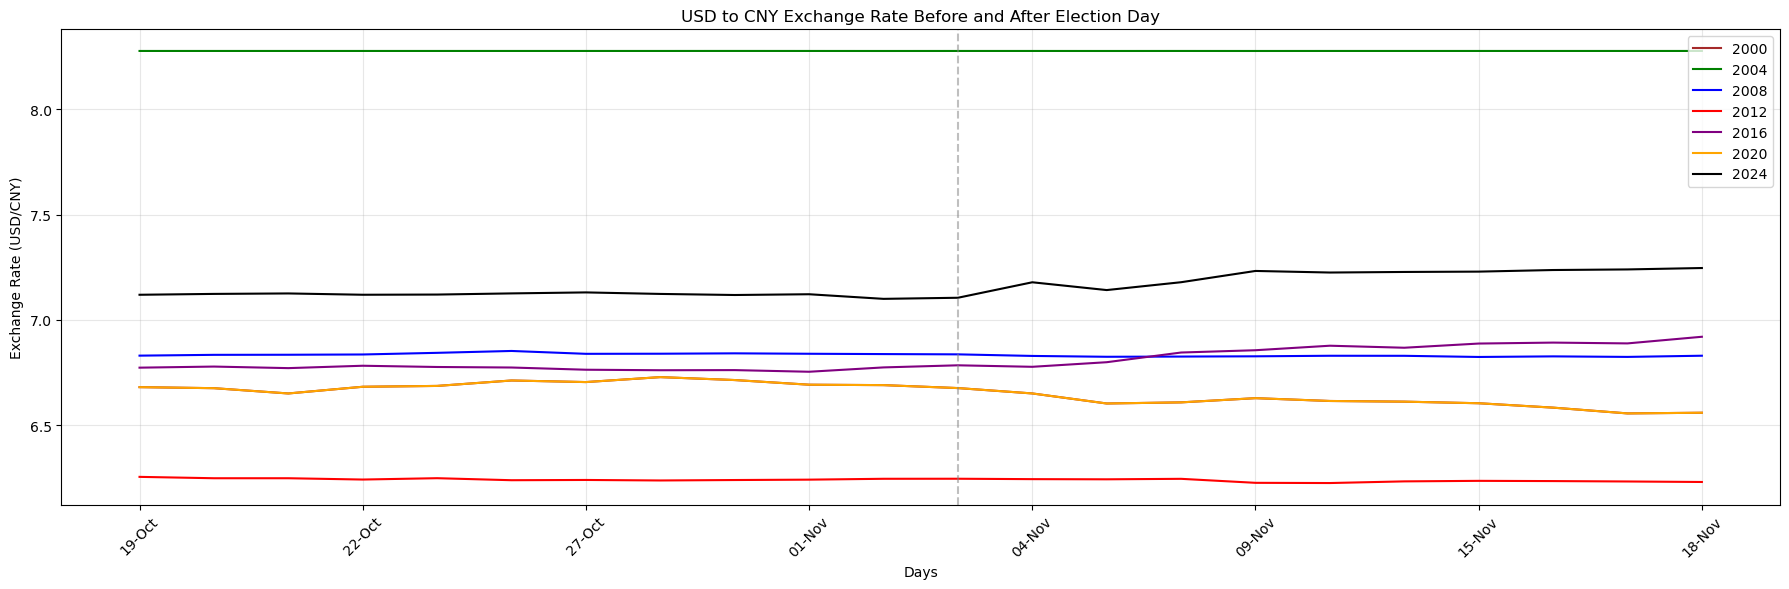

In [19]:
# USE THIS FOR FINAL PLOT
plt.clf()

# Create the figure
plt.figure(figsize=(18, 6))

# Plot each line using the combo dataframes and DayMonth column
plt.plot(range(len(exchange_rates_2000_combo)), exchange_rates_2000_combo['CNY'], label='2000', color='brown')
plt.plot(range(len(exchange_rates_2004_combo)), exchange_rates_2004_combo['CNY'], label='2004', color='green')
plt.plot(range(len(exchange_rates_2008_combo)), exchange_rates_2008_combo['CNY'], label='2008', color='blue')
plt.plot(range(len(exchange_rates_2012_combo)), exchange_rates_2012_combo['CNY'], label='2012', color='red')
plt.plot(range(len(exchange_rates_2016_combo)), exchange_rates_2016_combo['CNY'], label='2016', color='purple')
plt.plot(range(len(exchange_rates_2020_combo)), exchange_rates_2020_combo['CNY'], label='2020', color='orange')
plt.plot(range(len(exchange_rates_2024_combo)), exchange_rates_2024_combo['CNY'], label='2024', color='black')

# Customize the plot
plt.title('USD to CNY Exchange Rate Before and After Election Day')
plt.xlabel('Days')
plt.ylabel('Exchange Rate (USD/CNY)')

# Use the DayMonth from one of the combo dataframes for x-axis labels
# Show every 3rd label to avoid overcrowding
x_ticks = range(0, len(exchange_rates_2004_combo), 3)
plt.xticks(x_ticks, exchange_rates_2004_combo['DayMonth'].iloc[x_ticks], rotation=45)

# Add vertical line at election day (middle point)
middle_idx = len(exchange_rates_2004_combo) // 2
plt.axvline(x=middle_idx, color='gray', linestyle='--', alpha=0.5)

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Add legend
plt.legend()

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the chart
plt.show()

## EUR

<Figure size 640x480 with 0 Axes>

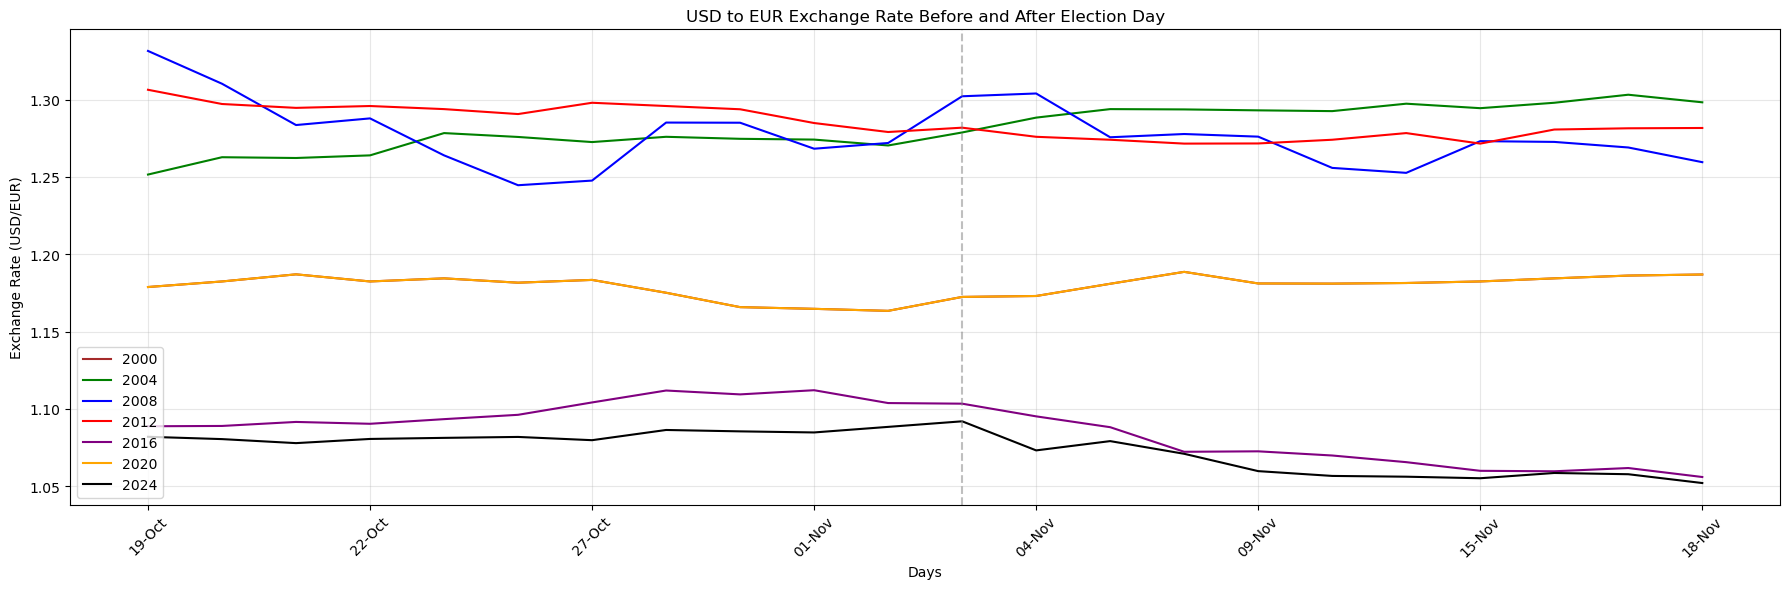

In [20]:
# USE THIS FOR FINAL PLOT

plt.clf()

# Create the figure
plt.figure(figsize=(18, 6))

# Plot each line using the combo dataframes and DayMonth column
plt.plot(range(len(exchange_rates_2000_combo)), exchange_rates_2000_combo['EUR'], label='2000', color='brown')
plt.plot(range(len(exchange_rates_2004_combo)), exchange_rates_2004_combo['EUR'], label='2004', color='green')
plt.plot(range(len(exchange_rates_2008_combo)), exchange_rates_2008_combo['EUR'], label='2008', color='blue')
plt.plot(range(len(exchange_rates_2012_combo)), exchange_rates_2012_combo['EUR'], label='2012', color='red')
plt.plot(range(len(exchange_rates_2016_combo)), exchange_rates_2016_combo['EUR'], label='2016', color='purple')
plt.plot(range(len(exchange_rates_2020_combo)), exchange_rates_2020_combo['EUR'], label='2020', color='orange')
plt.plot(range(len(exchange_rates_2024_combo)), exchange_rates_2024_combo['EUR'], label='2024', color='black')

# Customize the plot
plt.title('USD to EUR Exchange Rate Before and After Election Day')
plt.xlabel('Days')
plt.ylabel('Exchange Rate (USD/EUR)')

# Use the DayMonth from one of the combo dataframes for x-axis labels
# Show every 3rd label to avoid overcrowding - AI help
x_ticks = range(0, len(exchange_rates_2004_combo), 3)
plt.xticks(x_ticks, exchange_rates_2004_combo['DayMonth'].iloc[x_ticks], rotation=45)

# Add vertical line at election day (middle point)
middle_idx = len(exchange_rates_2004_combo) // 2
plt.axvline(x=middle_idx, color='gray', linestyle='--', alpha=0.5)

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Add legend
plt.legend()

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the chart
plt.show()

## JPY

<Figure size 640x480 with 0 Axes>

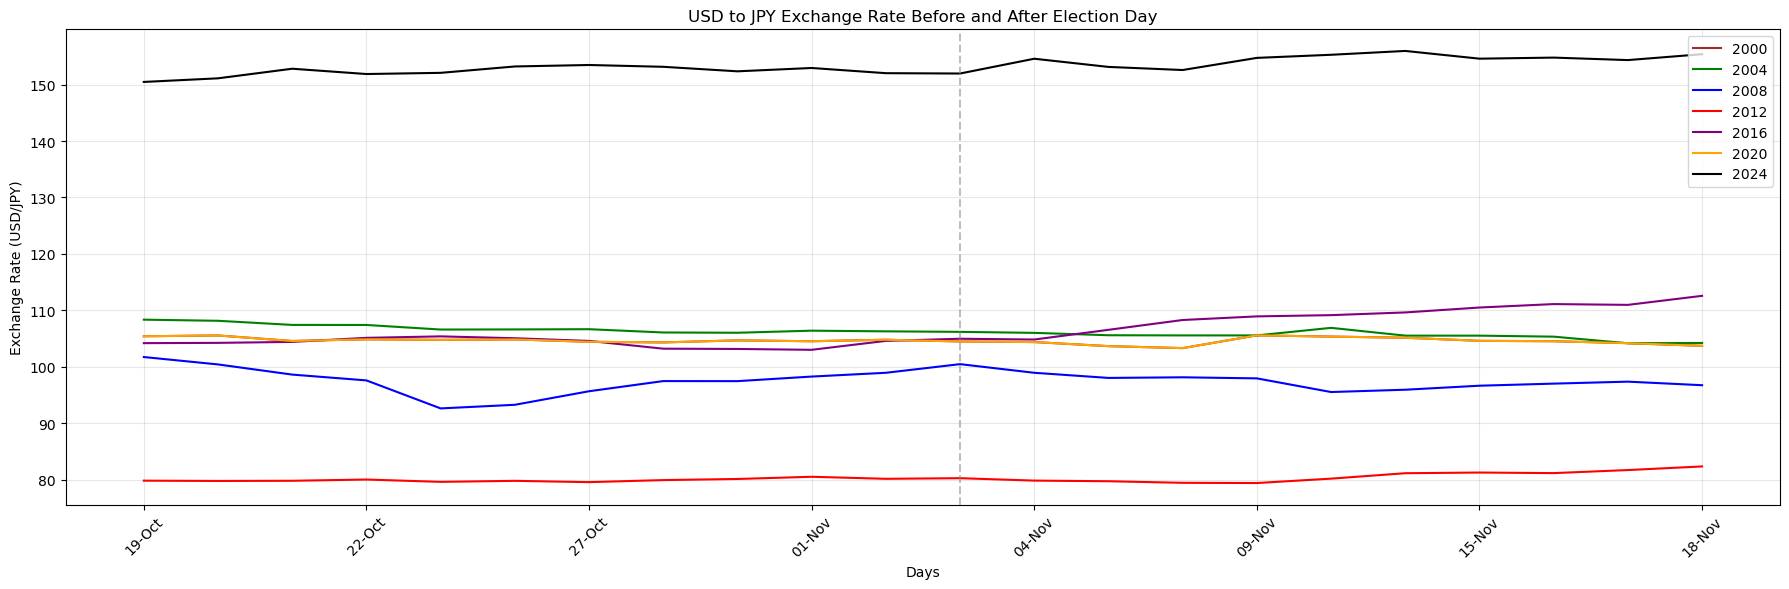

In [21]:
# USE THIS FOR FINAL PLOT

plt.clf()

# Create the figure
plt.figure(figsize=(18, 6))

# Plot each line using the combo dataframes and DayMonth column
plt.plot(range(len(exchange_rates_2000_combo)), exchange_rates_2000_combo['JPY'], label='2000', color='brown')
plt.plot(range(len(exchange_rates_2004_combo)), exchange_rates_2004_combo['JPY'], label='2004', color='green')
plt.plot(range(len(exchange_rates_2008_combo)), exchange_rates_2008_combo['JPY'], label='2008', color='blue')
plt.plot(range(len(exchange_rates_2012_combo)), exchange_rates_2012_combo['JPY'], label='2012', color='red')
plt.plot(range(len(exchange_rates_2016_combo)), exchange_rates_2016_combo['JPY'], label='2016', color='purple')
plt.plot(range(len(exchange_rates_2020_combo)), exchange_rates_2020_combo['JPY'], label='2020', color='orange')
plt.plot(range(len(exchange_rates_2024_combo)), exchange_rates_2024_combo['JPY'], label='2024', color='black')

# Customize the plot
plt.title('USD to JPY Exchange Rate Before and After Election Day')
plt.xlabel('Days')
plt.ylabel('Exchange Rate (USD/JPY)')

# Use the DayMonth from one of the combo dataframes for x-axis labels
# Show every 3rd label to avoid overcrowding
x_ticks = range(0, len(exchange_rates_2004_combo), 3)
plt.xticks(x_ticks, exchange_rates_2004_combo['DayMonth'].iloc[x_ticks], rotation=45)

# Add vertical line at election day (middle point)
middle_idx = len(exchange_rates_2004_combo) // 2
plt.axvline(x=middle_idx, color='gray', linestyle='--', alpha=0.5)

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Add legend
plt.legend()

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the chart
plt.show()

In [22]:
# Using the exchange_rates_2004_combo dataframe, create a copy to another data frame and drop the DayMonth column
exchange_rates_2004_combo_copy = exchange_rates_2004_combo.copy()
exchange_rates_2004_combo_copy.drop(columns='DayMonth', inplace=True)

display(exchange_rates_2004_combo_copy)

,CNY,JPY,EUR
Date,,,
2004-10-19,8.2765,108.36,1.2515
2004-10-20,8.2765,108.16,1.2627
2004-10-21,8.2765,107.43,1.2622
2004-10-22,8.2765,107.42,1.2639
2004-10-25,8.2765,106.61,1.2783
2004-10-26,8.2765,106.63,1.2758
2004-10-27,8.2765,106.67,1.2725
2004-10-28,8.2765,106.09,1.2759
2004-10-29,8.2766,106.04,1.2746


In [23]:
# Check for data types
exchange_rates_2004_combo_copy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22 entries, 2004-10-19 to 2004-11-18
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CNY     22 non-null     float64
 1   JPY     22 non-null     float64
 2   EUR     22 non-null     float64
dtypes: float64(3)
memory usage: 704.0 bytes




 > Similar to the charts above, we combined the 3 currencies into one chart to show the 30 days movement. Due to the different ratios (nominal values) from each exchange rate, we use a normalization approach, a.k.a. a “min-max scaling”. This approach transforms ALL currency values to a common scale between 0 and 1, while maintaining relative patterns, thus make the trend amongst 3 different currencies easily visualized within the same scale. Due to a short amount of 30 days, the chart below does look a little jagged.

 

<Figure size 640x480 with 0 Axes>

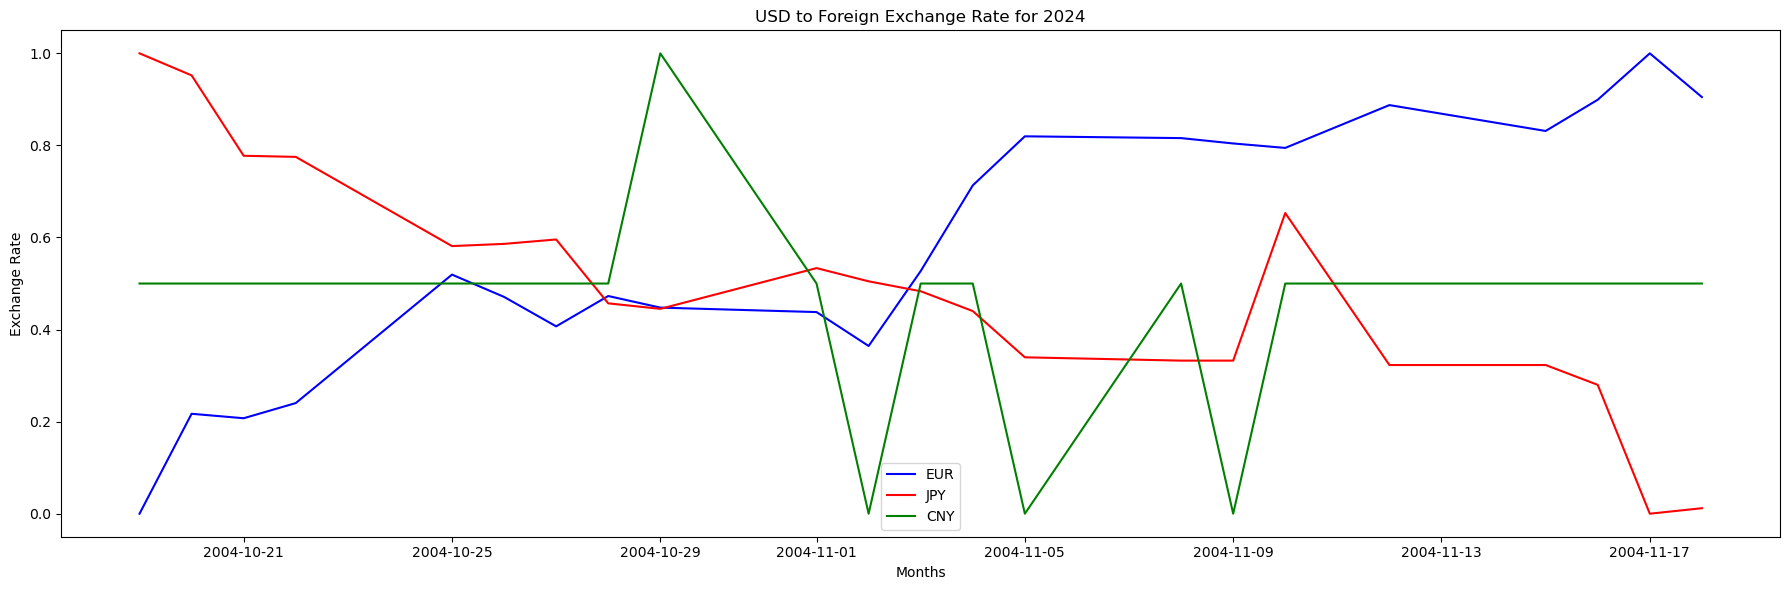

In [24]:
# Example of 30 day window for Election Year 2024
normalized_rates = exchange_rates_2004_combo_copy.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

plt.clf()
plt.figure(figsize=(18, 6))
plt.plot(normalized_rates.index, normalized_rates['EUR'], label='EUR', color='blue')
plt.plot(normalized_rates.index, normalized_rates['JPY'], label='JPY', color='red')
plt.plot(normalized_rates.index, normalized_rates['CNY'], label='CNY', color='green')
plt.title('USD to Foreign Exchange Rate for 2024')
plt.xlabel('Months')
plt.ylabel('Exchange Rate')

plt.legend()
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

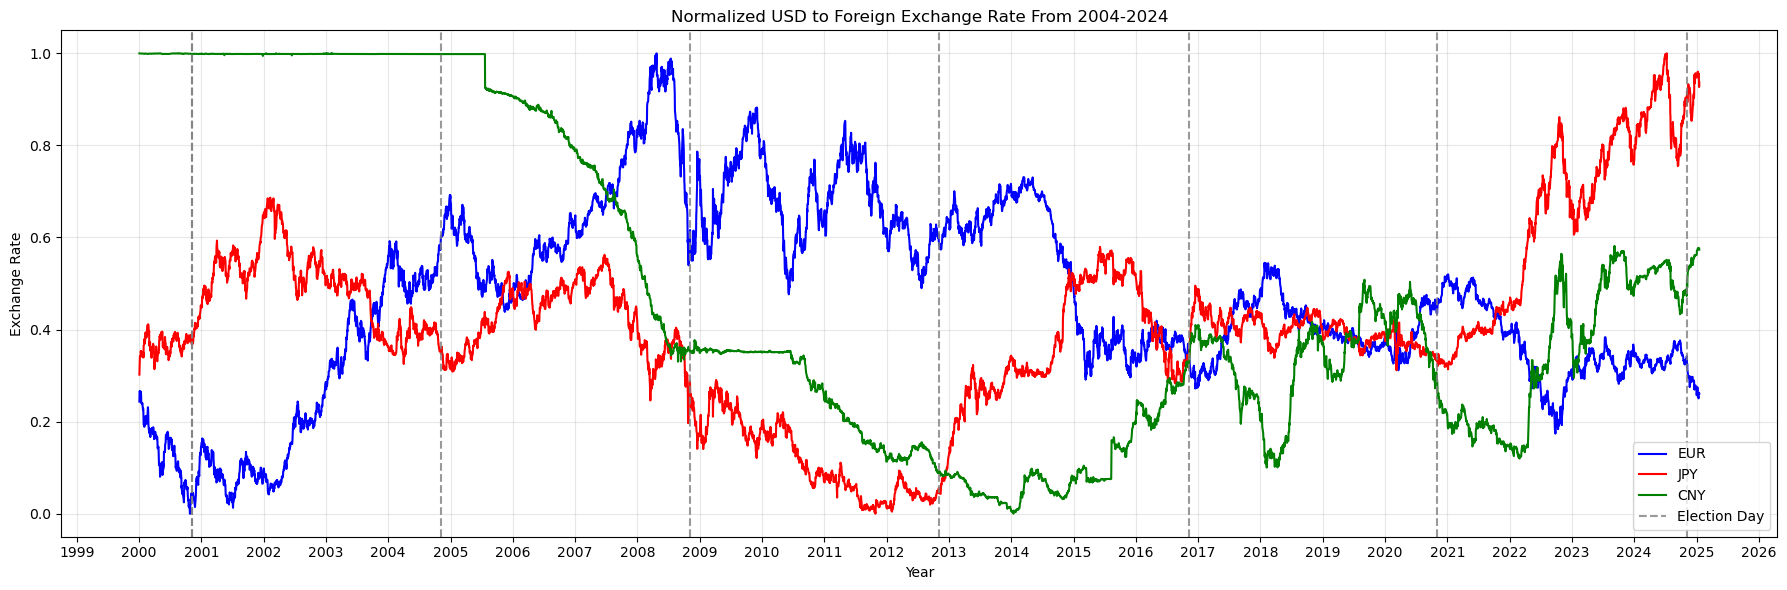

In [25]:
# Now let's make the chart shows the whole full 24 years of data.
# On this chart, we still use the normalization approach, but we expand the time frame to the 
# whole 24 years of our data (2000-2024). Each vertical dotted line represents the day of the 
# U.S. Presidential General Election Day.

normalized_rates = df_currency_rates.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

plt.clf()
plt.figure(figsize=(18, 6))
plt.plot(normalized_rates.index, normalized_rates['EUR'], label='EUR', color='blue')
plt.plot(normalized_rates.index, normalized_rates['JPY'], label='JPY', color='red')
plt.plot(normalized_rates.index, normalized_rates['CNY'], label='CNY', color='green')
plt.title('Normalized USD to Foreign Exchange Rate From 2004-2024')
plt.xlabel('Year')
plt.ylabel('Exchange Rate')

ax = plt.gca()  # Get the current axis
ax.xaxis.set_major_locator(mdates.YearLocator())  # Major ticks at the start of each month
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Format as abbreviated month names

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Add vertical line at election day (middle point)
# Loop through each date and add a vertical line
for date in election_dates:
    plt.axvline(x=date, color='gray', linestyle='--', alpha=0.8)

# Add a label for election dates (only once, to avoid repetition)
plt.axvline(x=election_dates[0], color='gray', linestyle='--', alpha=0.8, label='Election Day')

plt.legend()
plt.tight_layout()
plt.show()



# Step 3: Analyze the Data

Here, we'll calculate the volatility for each currency by calculating the percent change and then the standard deviation.
Our focus to is to see how the volatility of each currency changes form 2000 to 2024 with a focus of looking at the election periods. 

In [26]:
# Create a new column called 'Lagged Currency Rate' for all of the separated dataframes
df_china_daily['Lagged Currency Rate'] = df_china_daily['CNY'].shift(1)
df_euro_daily['Lagged Currency Rate'] = df_euro_daily['EUR'].shift(1)
df_japan_daily['Lagged Currency Rate'] = df_japan_daily['JPY'].shift(1)

# Add a column calculating the percent change with .pct_change() for all of the separated dataframes
df_china_daily['Daily Rate Change'] = df_china_daily['CNY'].astype(float).pct_change()
df_euro_daily['Daily Rate Change'] = df_euro_daily['EUR'].astype(float).pct_change()
df_japan_daily['Daily Rate Change'] = df_japan_daily['JPY'].astype(float).pct_change()
 
# Add a column with the volatility of the exchanges rates on a monthly bases with a rolling window of 4 days using df_currency_rates
df_china_daily['Currency Volatility'] = df_china_daily['Daily Rate Change'].rolling(window=7).std()
df_euro_daily['Currency Volatility'] = df_euro_daily['Daily Rate Change'].rolling(window=7).std()
df_japan_daily['Currency Volatility'] = df_japan_daily['Daily Rate Change'].rolling(window=7).std()

/var/folders/yg/wczv5tr14310nbkhj3m8dkkh0000gn/T/ipykernel_45019/1545906269.py:7: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_china_daily['Daily Rate Change'] = df_china_daily['CNY'].astype(float).pct_change()
/var/folders/yg/wczv5tr14310nbkhj3m8dkkh0000gn/T/ipykernel_45019/1545906269.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_euro_daily['Daily Rate Change'] = df_euro_daily['EUR'].astype(float).pct_change()
/var/folders/yg/wczv5tr14310nbkhj3m8dkkh0000gn/T/ipykernel_45019/1545906269.py:9: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be 

In [27]:
# Let's preview our currency data frames with the newly added columns
display(df_china_daily.head(10))
display(df_euro_daily.head(10))
display(df_japan_daily.head(10))

,CNY,Lagged Currency Rate,Daily Rate Change,Currency Volatility
Date,,,,
2000-01-03,8.2798,None,NaN,NaN
2000-01-04,8.2799,8.2798,0.000012,NaN
2000-01-05,8.2798,8.2799,-0.000012,NaN
2000-01-06,8.2797,8.2798,-0.000012,NaN
2000-01-07,8.2794,8.2797,-0.000036,NaN
2000-01-10,8.2794,8.2794,0.000000,NaN
2000-01-11,8.2795,8.2794,0.000012,NaN
2000-01-12,8.2796,8.2795,0.000012,0.000018
2000-01-13,8.2798,8.2796,0.000024,0.000020


,EUR,Lagged Currency Rate,Daily Rate Change,Currency Volatility
Date,,,,
2000-01-03,1.0155,None,NaN,NaN
2000-01-04,1.0309,1.0155,0.015165,NaN
2000-01-05,1.0335,1.0309,0.002522,NaN
2000-01-06,1.0324,1.0335,-0.001064,NaN
2000-01-07,1.0294,1.0324,-0.002906,NaN
2000-01-10,1.0252,1.0294,-0.004080,NaN
2000-01-11,1.0322,1.0252,0.006828,NaN
2000-01-12,1.0281,1.0322,-0.003972,0.007102
2000-01-13,1.0270,1.0281,-0.001070,0.003961


,JPY,Lagged Currency Rate,Daily Rate Change,Currency Volatility
Date,,,,
2000-01-03,101.7000,None,NaN,NaN
2000-01-04,103.0900,101.7000,0.013668,NaN
2000-01-05,103.7700,103.0900,0.006596,NaN
2000-01-06,105.1900,103.7700,0.013684,NaN
2000-01-07,105.1700,105.1900,-0.000190,NaN
2000-01-10,105.2800,105.1700,0.001046,NaN
2000-01-11,106.0900,105.2800,0.007694,NaN
2000-01-12,105.7600,106.0900,-0.003111,0.006658
2000-01-13,106.0900,105.7600,0.003120,0.005652


<Figure size 640x480 with 0 Axes>

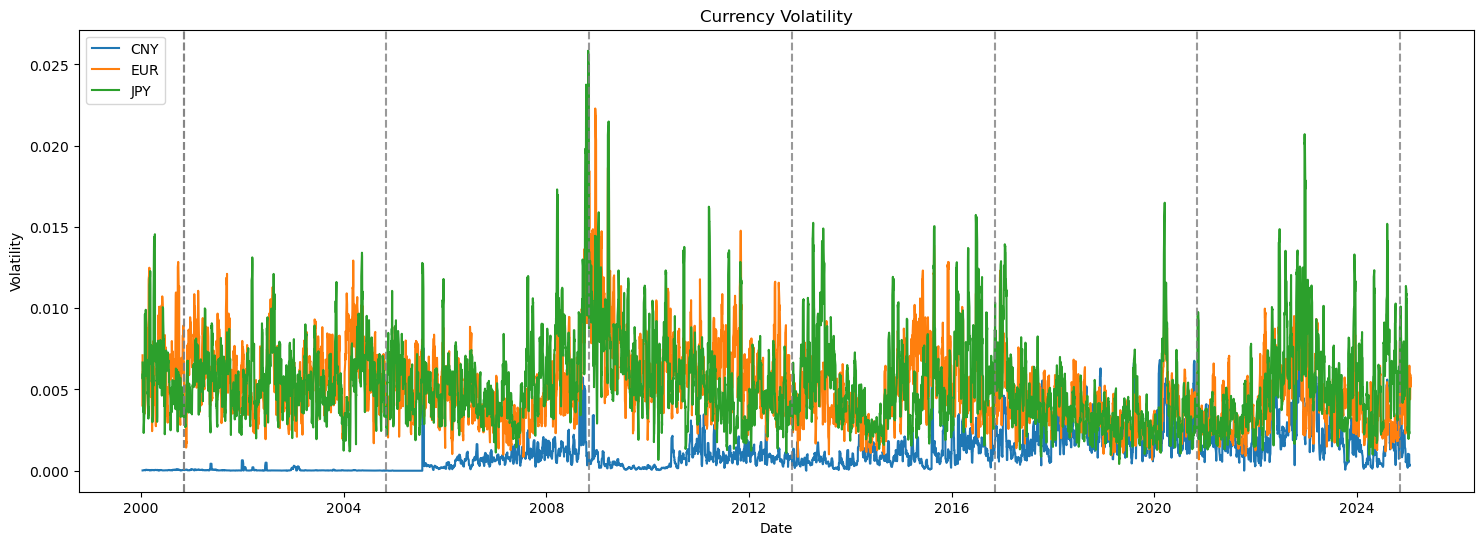

In [28]:
# Visualize the Volatility of CNY, EUR and JPY on one graph
plt.clf()
plt.figure(figsize=(18, 6))
plt.plot(df_china_daily['Currency Volatility'], label='CNY')
plt.plot(df_euro_daily['Currency Volatility'], label='EUR')
plt.plot(df_japan_daily['Currency Volatility'], label='JPY')
plt.legend()
plt.title('Currency Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')

# Add vertical line at election day (middle point)
# Loop through each date and add a vertical line
for date in election_dates:
    plt.axvline(x=date, color='gray', linestyle='--', alpha=0.8)

# Add a label for election dates (only once, to avoid repetition)
plt.axvline(x=election_dates[0], color='gray', linestyle='--', alpha=0.8, label='Election Day')
plt.show()

In [29]:
# Show the election windows approximately 15 days before and 15 days after the election day
election_windows

{2000: (Timestamp('2000-10-23 00:00:00'), Timestamp('2000-11-22 00:00:00')),
 2004: (Timestamp('2004-10-19 00:00:00'), Timestamp('2004-11-18 00:00:00')),
 2008: (Timestamp('2008-10-20 00:00:00'), Timestamp('2008-11-19 00:00:00')),
 2012: (Timestamp('2012-10-22 00:00:00'), Timestamp('2012-11-21 00:00:00')),
 2016: (Timestamp('2016-10-24 00:00:00'), Timestamp('2016-11-23 00:00:00')),
 2020: (Timestamp('2020-10-19 00:00:00'), Timestamp('2020-11-18 00:00:00')),
 2024: (Timestamp('2024-10-21 00:00:00'), Timestamp('2024-11-20 00:00:00'))}

<Figure size 640x480 with 0 Axes>

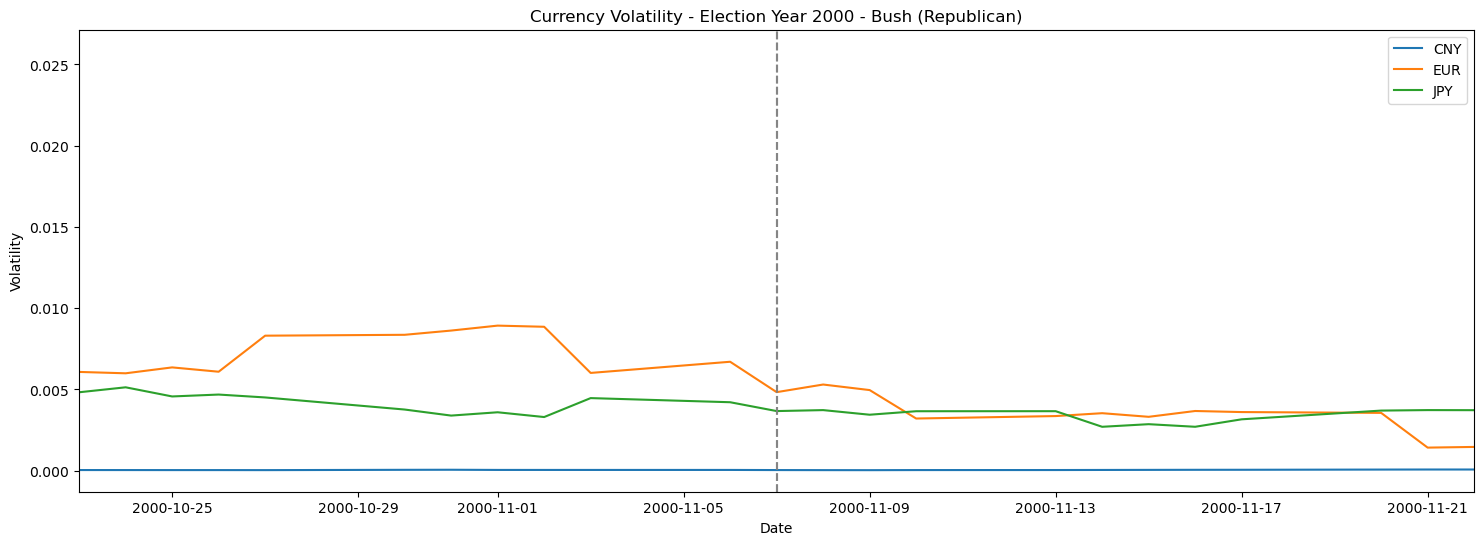

In [30]:
# Zoom in on the election years looking at the graph closer - 15 days before and 15 days after the election

# 2000 Election Year
plt.clf()
plt.figure(figsize=(18, 6))
plt.plot(df_china_daily['Currency Volatility'], label='CNY')
plt.plot(df_euro_daily['Currency Volatility'], label='EUR')
plt.plot(df_japan_daily['Currency Volatility'], label='JPY')
plt.legend()
plt.title('Currency Volatility - Election Year 2000 - Bush (Republican)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.xlim(pd.to_datetime(election_windows[2000][0]), pd.to_datetime(election_windows[2000][1]))
# Add vertical line at election day (middle point)
for date in election_dates:
    plt.axvline(x=date, color='gray', linestyle='--', alpha=0.8)
plt.axvline(x=election_dates[0], color='gray', linestyle='--', alpha=0.8, label='Election Day')
plt.show()

<Figure size 640x480 with 0 Axes>

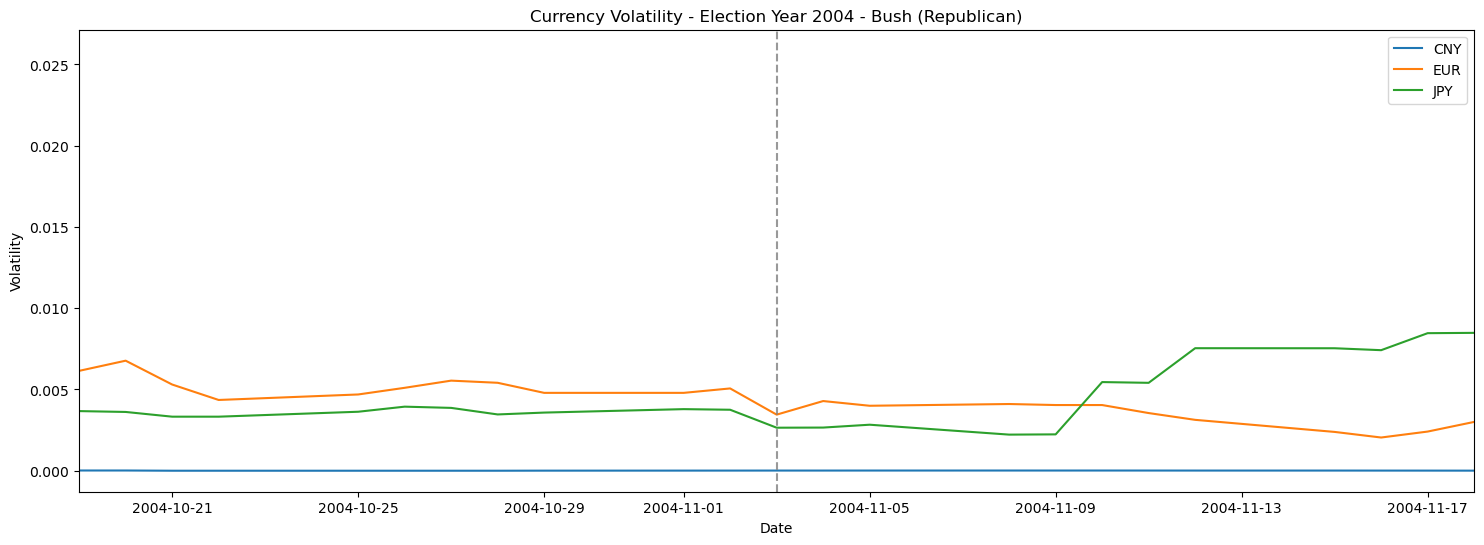

In [31]:
# 2004 Election Year
plt.clf()
plt.figure(figsize=(18, 6))
plt.plot(df_china_daily['Currency Volatility'], label='CNY')
plt.plot(df_euro_daily['Currency Volatility'], label='EUR')
plt.plot(df_japan_daily['Currency Volatility'], label='JPY')
plt.legend()
plt.title('Currency Volatility - Election Year 2004 - Bush (Republican)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.xlim(pd.to_datetime(election_windows[2004][0]), pd.to_datetime(election_windows[2004][1]))
# Add vertical line at election day (middle point)
for date in election_dates:
    plt.axvline(x=date, color='gray', linestyle='--', alpha=0.8)
plt.axvline(x=election_dates[0], color='gray', linestyle='--', alpha=0.8, label='Election Day')
plt.show()

<Figure size 640x480 with 0 Axes>

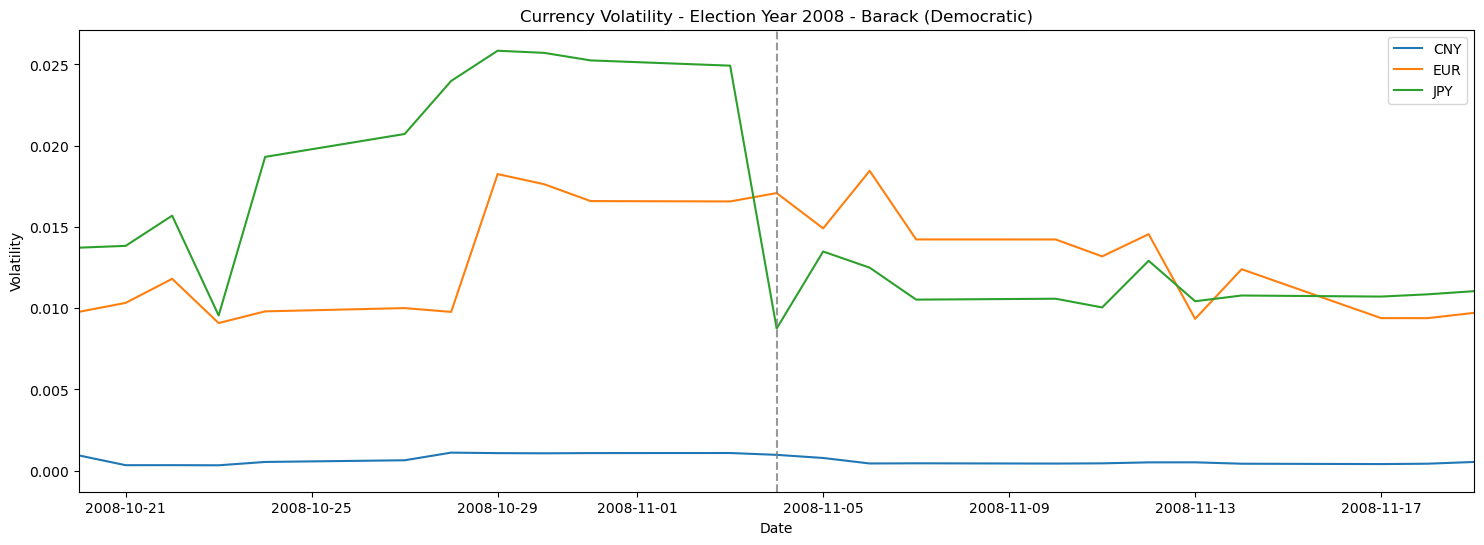

In [32]:
# 2008 Election Year
plt.clf()
plt.figure(figsize=(18, 6))
plt.plot(df_china_daily['Currency Volatility'], label='CNY')
plt.plot(df_euro_daily['Currency Volatility'], label='EUR')
plt.plot(df_japan_daily['Currency Volatility'], label='JPY')
plt.legend()
plt.title('Currency Volatility - Election Year 2008 - Barack (Democratic)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.xlim(pd.to_datetime(election_windows[2008][0]), pd.to_datetime(election_windows[2008][1]))
# Add vertical line at election day (middle point)
for date in election_dates:
    plt.axvline(x=date, color='gray', linestyle='--', alpha=0.8)
plt.axvline(x=election_dates[0], color='gray', linestyle='--', alpha=0.8, label='Election Day')
plt.show()

<Figure size 640x480 with 0 Axes>

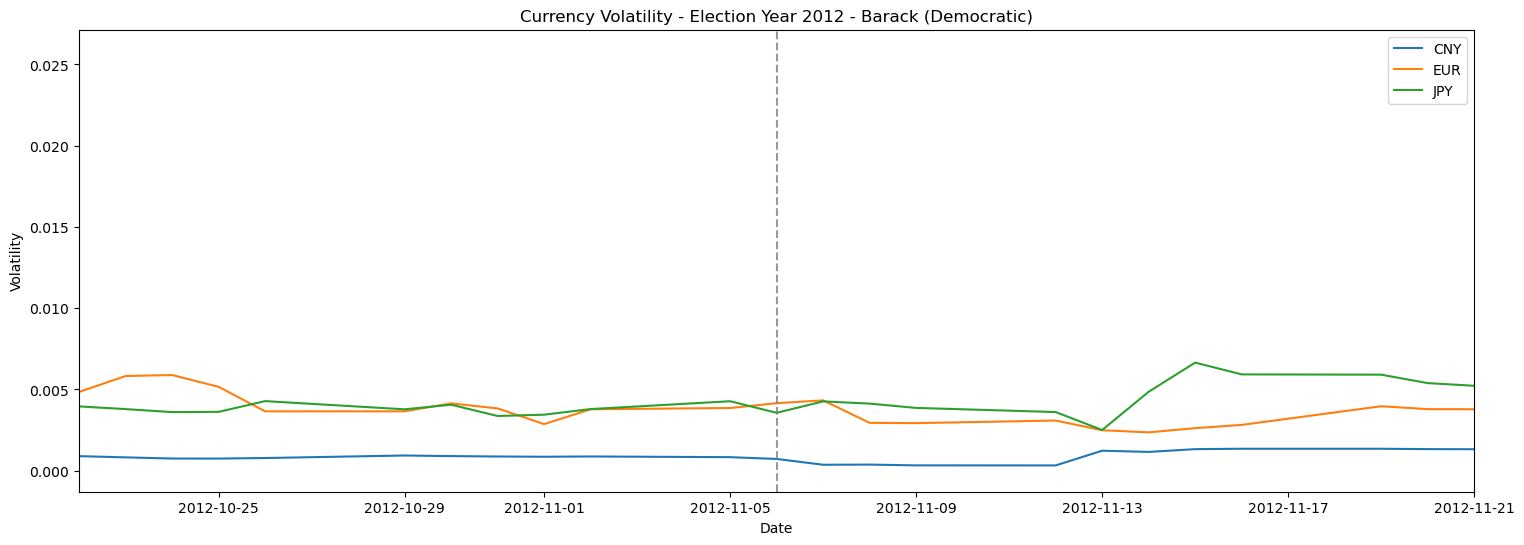

In [33]:
# 2012 Election Year
plt.clf()
plt.figure(figsize=(18, 6))
plt.plot(df_china_daily['Currency Volatility'], label='CNY')
plt.plot(df_euro_daily['Currency Volatility'], label='EUR')
plt.plot(df_japan_daily['Currency Volatility'], label='JPY')
plt.legend()
plt.title('Currency Volatility - Election Year 2012 - Barack (Democratic)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.xlim(pd.to_datetime(election_windows[2012][0]), pd.to_datetime(election_windows[2012][1]))
# Add vertical line at election day (middle point)
for date in election_dates:
    plt.axvline(x=date, color='gray', linestyle='--', alpha=0.8)
plt.axvline(x=election_dates[0], color='gray', linestyle='--', alpha=0.8, label='Election Day')
plt.show()

<Figure size 640x480 with 0 Axes>

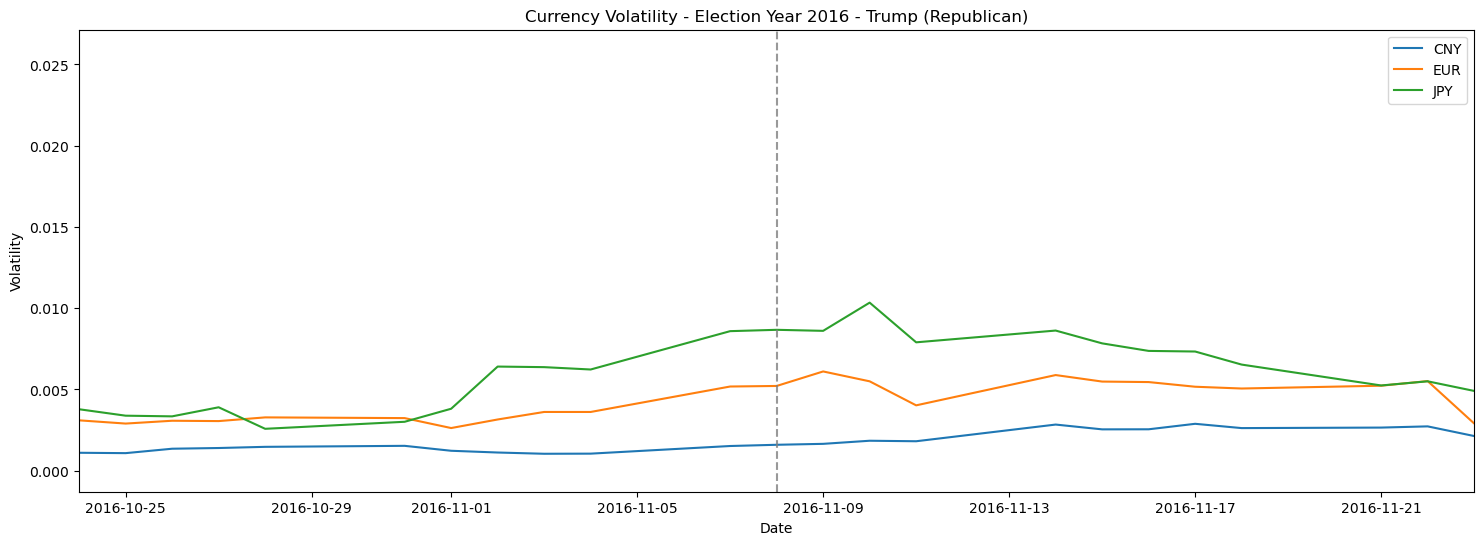

In [34]:
# 2016 Election Year
plt.clf()
plt.figure(figsize=(18, 6))
plt.plot(df_china_daily['Currency Volatility'], label='CNY')
plt.plot(df_euro_daily['Currency Volatility'], label='EUR')
plt.plot(df_japan_daily['Currency Volatility'], label='JPY')
plt.legend()
plt.title('Currency Volatility - Election Year 2016 - Trump (Republican)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.xlim(pd.to_datetime(election_windows[2016][0]), pd.to_datetime(election_windows[2016][1]))
# Add vertical line at election day (middle point)
for date in election_dates:
    plt.axvline(x=date, color='gray', linestyle='--', alpha=0.8)
plt.axvline(x=election_dates[0], color='gray', linestyle='--', alpha=0.8, label='Election Day')
plt.show()

<Figure size 640x480 with 0 Axes>

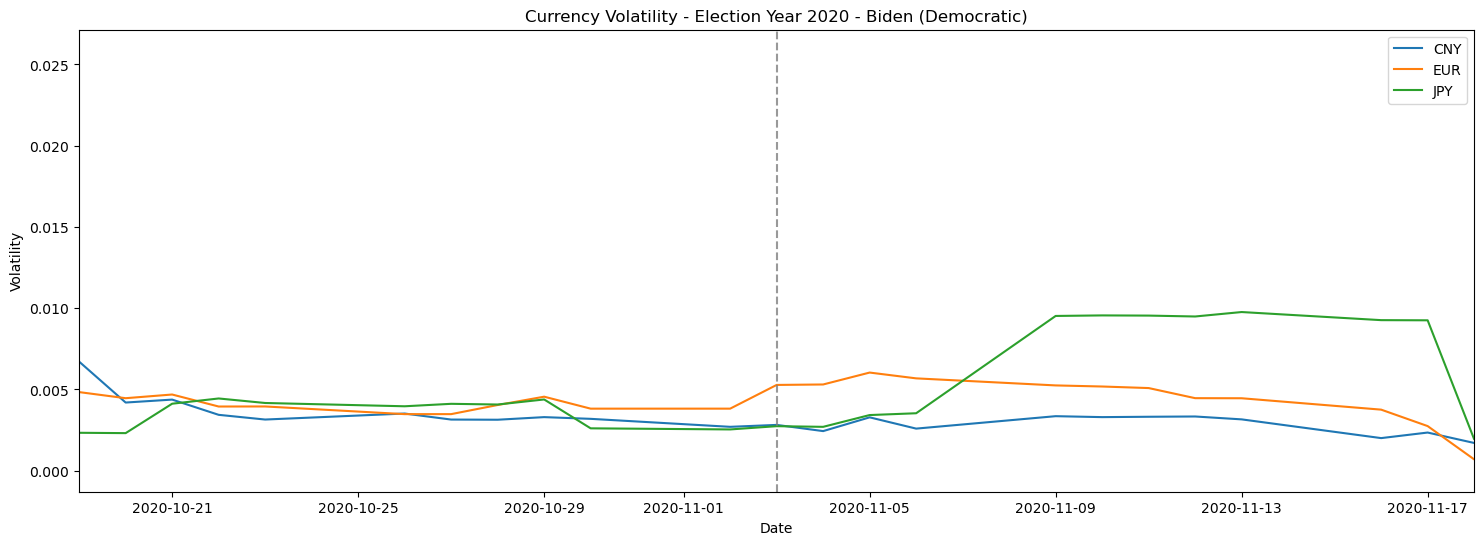

In [35]:
# 2020 Election Year
plt.clf()
plt.figure(figsize=(18, 6))
plt.plot(df_china_daily['Currency Volatility'], label='CNY')
plt.plot(df_euro_daily['Currency Volatility'], label='EUR')
plt.plot(df_japan_daily['Currency Volatility'], label='JPY')
plt.legend()
plt.title('Currency Volatility - Election Year 2020 - Biden (Democratic)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.xlim(pd.to_datetime(election_windows[2020][0]), pd.to_datetime(election_windows[2020][1]))
# Add vertical line at election day (middle point)
for date in election_dates:
    plt.axvline(x=date, color='gray', linestyle='--', alpha=0.8)
plt.axvline(x=election_dates[0], color='gray', linestyle='--', alpha=0.8, label='Election Day')
plt.show()

<Figure size 640x480 with 0 Axes>

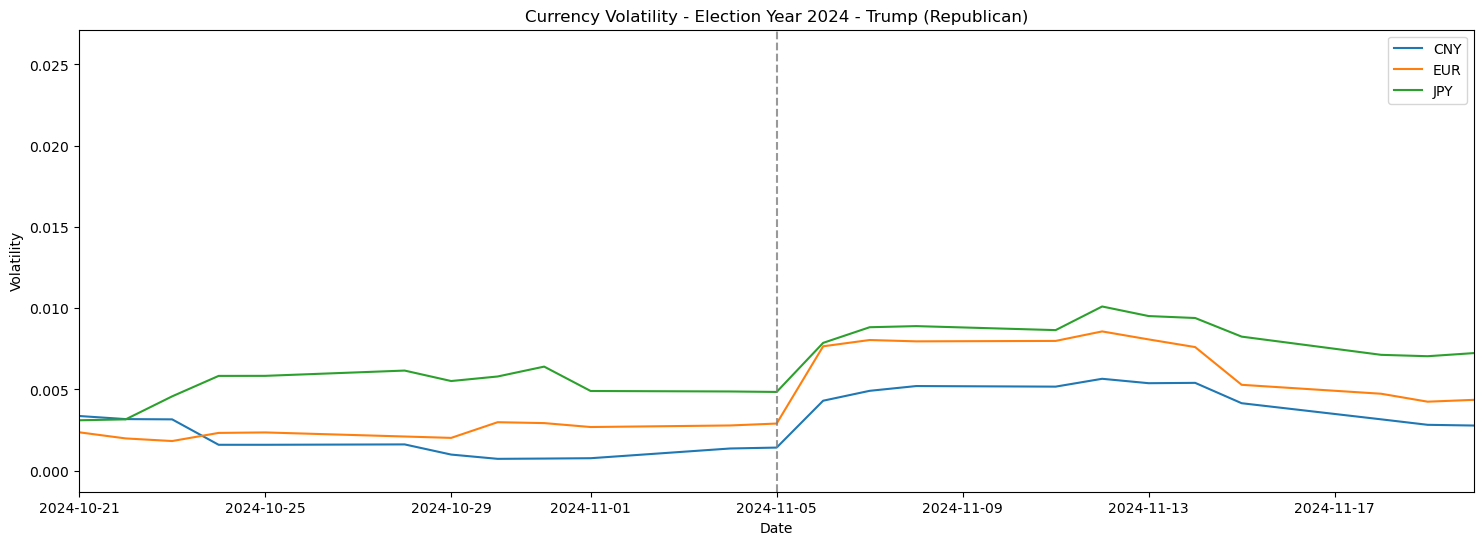

In [36]:
# 2024 Election Year
plt.clf()
plt.figure(figsize=(18, 6))
plt.plot(df_china_daily['Currency Volatility'], label='CNY')
plt.plot(df_euro_daily['Currency Volatility'], label='EUR')
plt.plot(df_japan_daily['Currency Volatility'], label='JPY')
plt.legend()
plt.title('Currency Volatility - Election Year 2024 - Trump (Republican)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.xlim(pd.to_datetime(election_windows[2024][0]), pd.to_datetime(election_windows[2024][1]))
# Add vertical line at election day (middle point)
for date in election_dates:
    plt.axvline(x=date, color='gray', linestyle='--', alpha=0.8)
plt.axvline(x=election_dates[0], color='gray', linestyle='--', alpha=0.8, label='Election Day')
plt.show()

# Step 4: Volatility Analysis

Investigate a certain date range to see how all three currencies perform around the 2024 election year. We'll also choose a non-election year of 2022 so we have something to compare it to. This year is selected as it's the closest one to the 2024 election year and it's after Covid time.

In [37]:
# Set variables for the start and end date for 2022 and 2024
start_date_2022 = '2022-06-22'
end_date_2022 = '2022-12-31'

start_date_2024 = '2024-06-22'
end_date_2024 = '2024-12-31'

# Slice the full data frame into the start and end dates for 2022 and 2024
df_china_daily_zoom_2022 = df_china_daily.loc[start_date_2022:end_date_2022]
df_china_daily_zoom_2024 = df_china_daily.loc[start_date_2024:end_date_2024]
df_euro_daily_zoom_2022 = df_euro_daily.loc[start_date_2022:end_date_2022]
df_euro_daily_zoom_2024 = df_euro_daily.loc[start_date_2024:end_date_2024]
df_japan_daily_zoom_2022 = df_japan_daily.loc[start_date_2022:end_date_2022]
df_japan_daily_zoom_2024 = df_japan_daily.loc[start_date_2024:end_date_2024]


<Figure size 640x480 with 0 Axes>

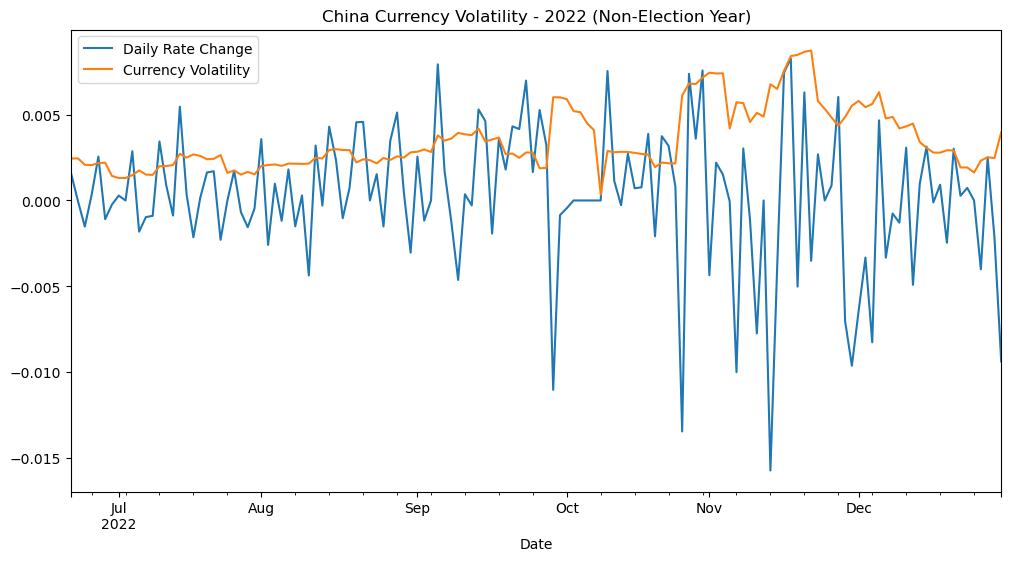

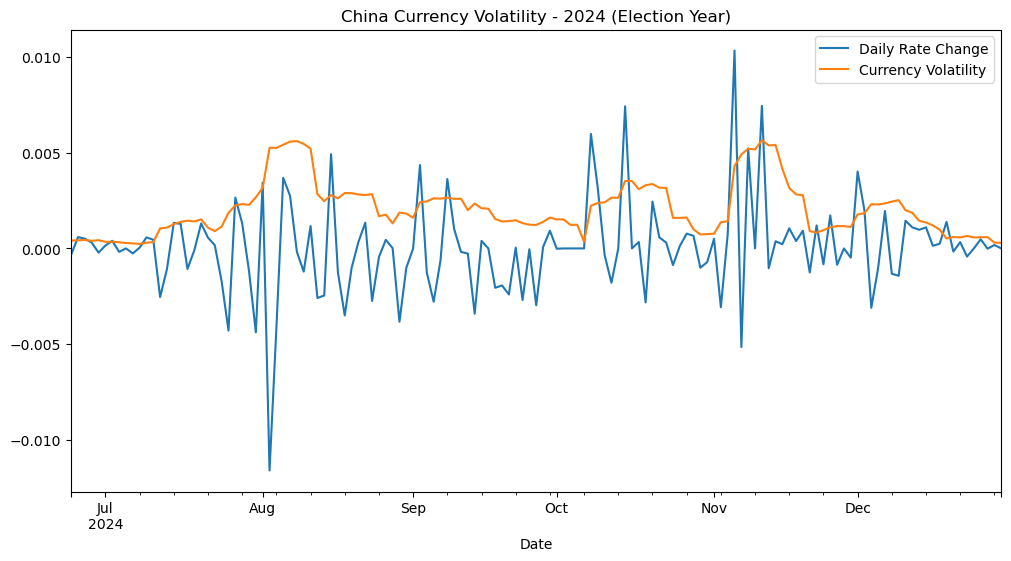

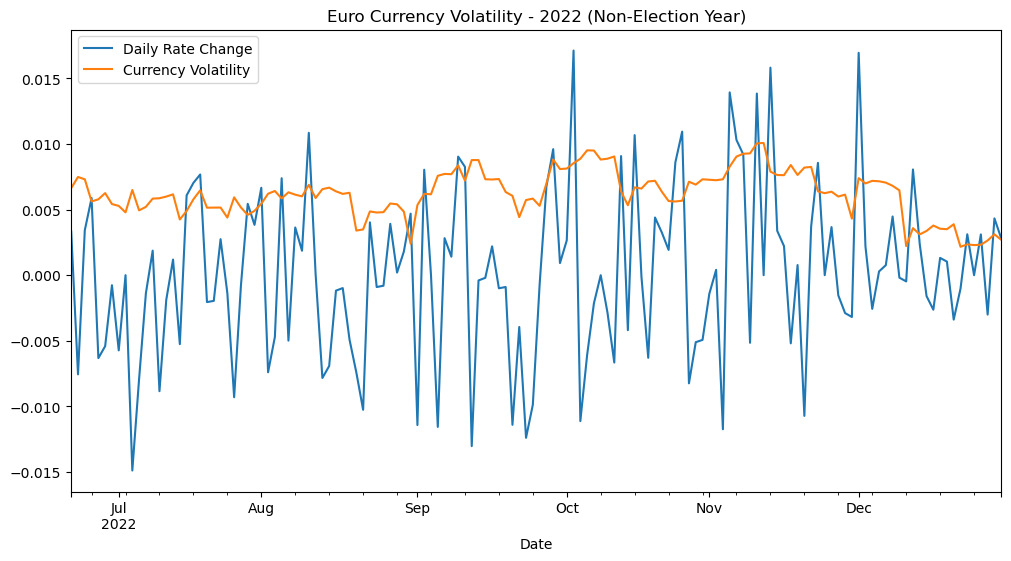

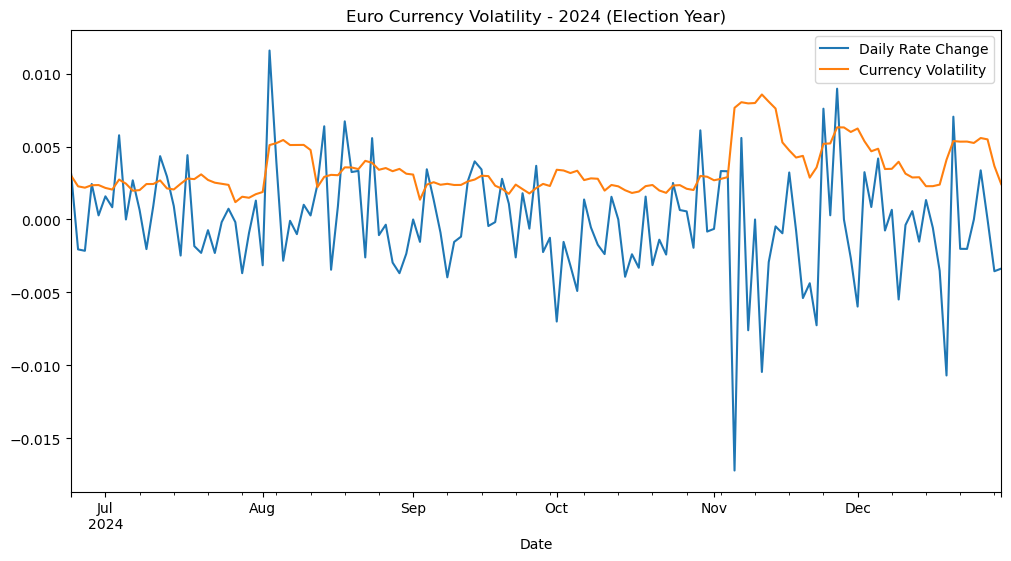

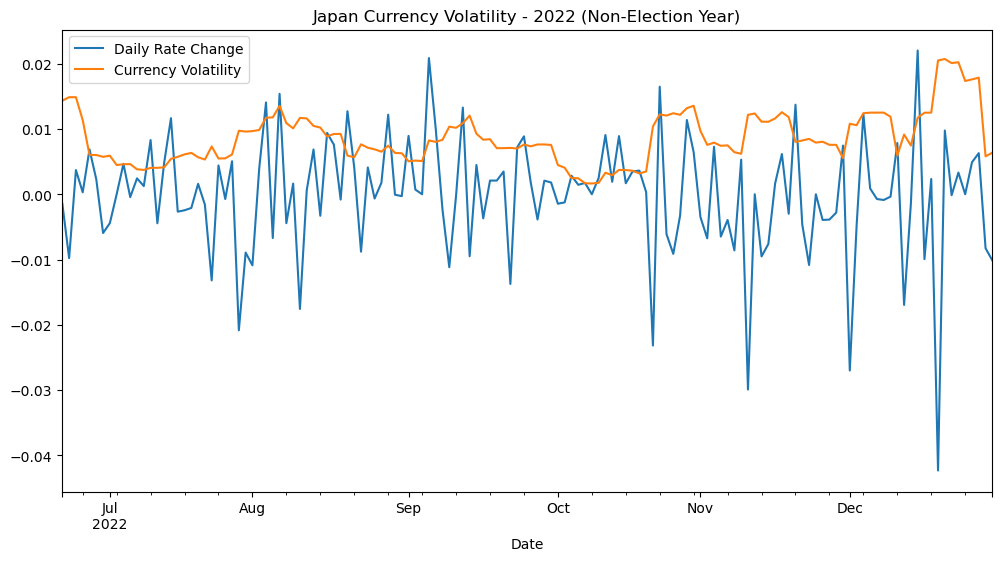

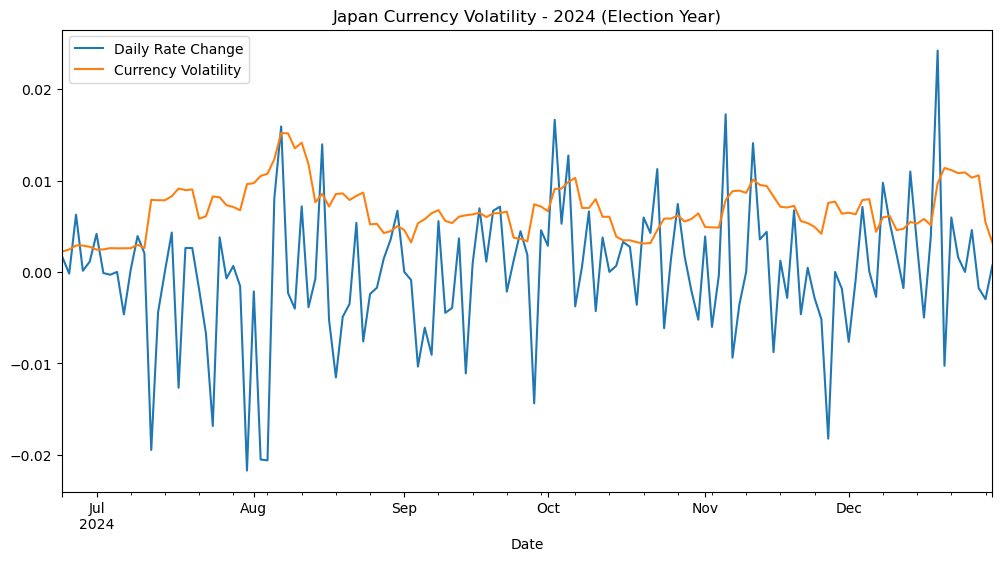

In [38]:
# Show the plots for CNY, EUR, and JPY Volatility
plt.clf()
df_china_daily_zoom_2022.plot(figsize=(12, 6), title="China Currency Volatility - 2022 (Non-Election Year)")
df_china_daily_zoom_2024.plot(figsize=(12, 6), title="China Currency Volatility - 2024 (Election Year)")
df_euro_daily_zoom_2022.plot(figsize=(12, 6), title="Euro Currency Volatility - 2022 (Non-Election Year)")
df_euro_daily_zoom_2024.plot(figsize=(12, 6), title="Euro Currency Volatility - 2024 (Election Year)")
df_japan_daily_zoom_2022.plot(figsize=(12, 6), title="Japan Currency Volatility - 2022 (Non-Election Year)")
df_japan_daily_zoom_2024.plot(figsize=(12, 6), title="Japan Currency Volatility - 2024 (Election Year)")
plt.show()

# Step 5: Mine Exchange Rate Data for Seasonality

Mine the exchange rate data for predictable seasonal patterns

1. Group the daily exchange rate data to plot the average rate by day of the week. 
2. Group the daily exchange rate data to plot the average rate by week of the year. 


In [39]:
# Convert the CNY to the datatype float in df_china_daily
df_china_daily['CNY'] = df_china_daily['CNY'].astype(float)
df_china_daily['Lagged Currency Rate'] = df_china_daily['Lagged Currency Rate'].astype(float)

df_euro_daily['EUR'] = df_euro_daily['EUR'].astype(float)
df_euro_daily['Lagged Currency Rate'] = df_china_daily['Lagged Currency Rate'].astype(float)

df_japan_daily['JPY'] = df_japan_daily['JPY'].astype(float)
df_japan_daily['Lagged Currency Rate'] = df_china_daily['Lagged Currency Rate'].astype(float)

<Figure size 640x480 with 0 Axes>

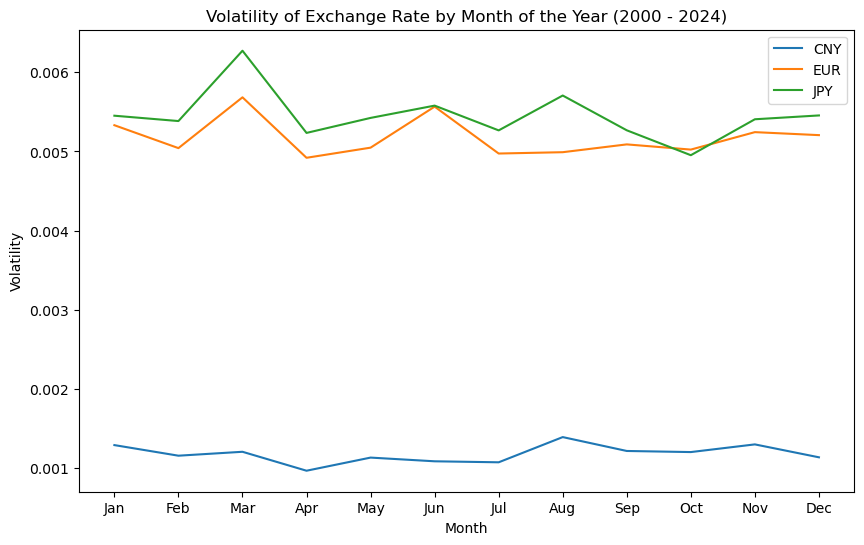

In [40]:
# Group the daily exchange rate data to plot the average rate by month of year
median_montly_exchange_CNY = df_china_daily.groupby(df_china_daily.index.month).mean()
median_montly_exchange_EUR = df_euro_daily.groupby(df_euro_daily.index.month).mean()
median_montly_exchange_JPY = df_japan_daily.groupby(df_japan_daily.index.month).mean()

# Plot the volatility by month of year
plt.clf()
fig, ax = plt.subplots(figsize=(10, 6))
median_montly_exchange_CNY['Currency Volatility'].plot(ax=ax)
median_montly_exchange_EUR['Currency Volatility'].plot(ax=ax)
median_montly_exchange_JPY['Currency Volatility'].plot(ax=ax)

# Set custom x-ticks with month names
ax.set_xticks(range(1, 13))  # Set x-axis ticks to 1-12
ax.set_xticklabels(calendar.month_abbr[1:])  # Replace numbers with abbreviated month names
plt.xlabel('Month')
plt.ylabel('Volatility')
plt.legend(['CNY', 'EUR', 'JPY'])
plt.title('Volatility of Exchange Rate by Month of the Year (2000 - 2024)')
plt.show()

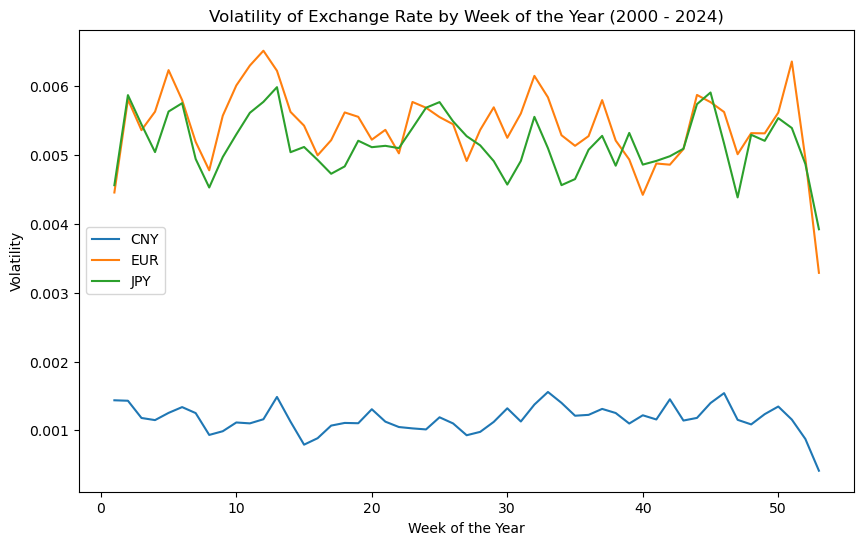

In [41]:
# Group the daily exchange rate data to plot the average rate by week of the year
median_weekly_exchange_CNY = df_china_daily.groupby(df_china_daily.index.isocalendar().week).mean()
median_weekly_exchange_EUR = df_euro_daily.groupby(df_euro_daily.index.isocalendar().week).mean()
median_weekly_exchange_JPY = df_japan_daily.groupby(df_japan_daily.index.isocalendar().week).mean()

# Plot the weekly exchange rate data
plt.clf()
median_weekly_exchange_CNY['Currency Volatility'].plot(figsize=(10, 6), ylabel='Volatility')
median_weekly_exchange_JPY['Currency Volatility'].plot()
median_weekly_exchange_EUR['Currency Volatility'].plot()
plt.legend(['CNY', 'EUR', 'JPY'])
plt.xlabel('Week of the Year')
plt.title('Volatility of Exchange Rate by Week of the Year (2000 - 2024)')
plt.show()
plt.show()

In [42]:
# Preview the head and tail
display(df_china_daily.head())
display(df_china_daily.tail())

,CNY,Lagged Currency Rate,Daily Rate Change,Currency Volatility
Date,,,,
2000-01-03,8.2798,NaN,NaN,NaN
2000-01-04,8.2799,8.2798,0.000012,NaN
2000-01-05,8.2798,8.2799,-0.000012,NaN
2000-01-06,8.2797,8.2798,-0.000012,NaN
2000-01-07,8.2794,8.2797,-0.000036,NaN


,CNY,Lagged Currency Rate,Daily Rate Change,Currency Volatility
Date,,,,
2025-01-13,7.3319,7.3326,-0.000095,0.001000
2025-01-14,7.3311,7.3319,-0.000109,0.000322
2025-01-15,7.3304,7.3311,-0.000095,0.000337
2025-01-16,7.3316,7.3304,0.000164,0.000288
2025-01-17,7.3249,7.3316,-0.000914,0.000361


# Step 6: Correlation Study

In this section, we'll investigate the correlation between the sitting political party (Democratic or Republican) on the exchange rates. 

In [43]:
# Generate a dataframe where the index is the date from 2000-01-03 to 2024-12-31 with the column Party
df_party = pd.DataFrame(index=pd.date_range('2000-01-03', '2024-12-31'), columns=['Party'])

# name the index column as Date
df_party.index.name = 'Date'
df_party = df_party.reset_index()
df_party['Date'] = pd.to_datetime(df_party['Date'])

# preview the head and tail
display(df_party.head())
display(df_party.tail())


,Date,Party
0,2000-01-03,NaN
1,2000-01-04,NaN
2,2000-01-05,NaN
3,2000-01-06,NaN
4,2000-01-07,NaN


,Date,Party
9125,2024-12-27,NaN
9126,2024-12-28,NaN
9127,2024-12-29,NaN
9128,2024-12-30,NaN
9129,2024-12-31,NaN


In [44]:
# Create a function with multiple conditions that will assign the correct value where 0 - Republican and 1 - Democratic
def assign_party(date):
    year = date.year
    if year >= 2000 and year < 2001: # Clinton (Democratic)
        return 1
    elif year >= 2001 and year < 2009: # Bush (Republic)
        return 0
    elif year >= 2009 and year < 2017: # Barack (Democratic)
        return 1
    elif year >= 2017 and year < 2021: # Trump (Republic)
        return 0
    elif year >= 2021 and year < 2025: # Biden (Democratic)
        return 1
    else:
        return None

In [45]:
# Apply our function to the df_party 
df_party['Party'] = df_party['Date'].apply(assign_party) 

In [46]:
# Reset the df_party index as the date
df_party = df_party.set_index('Date')

In [47]:
# Export df_party to a csv file to check
df_party.to_csv('Resources/df_party.csv', index=False)

In [48]:
# Concatenate the exchange rate DataFrame with the df_party DataFrame
# Concatenate the DataFrame by columns (axis=1), and drop and rows with only one column of data
exchange_party_trends_CNY_df = pd.concat([df_china_daily, df_party],axis='columns', join='inner').dropna()
exchange_party_trends_EUR_df = pd.concat([df_euro_daily, df_party],axis='columns', join='inner').dropna()
exchange_party_trends_JPY_df = pd.concat([df_japan_daily, df_party],axis='columns', join='inner').dropna()

# View the first and last five rows of the a DataFrame to check
display(exchange_party_trends_CNY_df.head())
display(exchange_party_trends_CNY_df.tail())

,CNY,Lagged Currency Rate,Daily Rate Change,Currency Volatility,Party
Date,,,,,
2000-01-12,8.2796,8.2795,0.000012,0.000018,1
2000-01-13,8.2798,8.2796,0.000024,0.000020,1
2000-01-14,8.2797,8.2798,-0.000012,0.000020,1
2000-01-19,8.2797,8.2793,0.000048,0.000030,1
2000-01-20,8.2794,8.2797,-0.000036,0.000034,1


,CNY,Lagged Currency Rate,Daily Rate Change,Currency Volatility,Party
Date,,,,,
2024-12-23,7.2977,7.2953,0.000329,0.000577,1
2024-12-24,7.2946,7.2977,-0.000425,0.000652,1
2024-12-27,7.2980,7.2981,-0.000014,0.000592,1
2024-12-30,7.2993,7.2980,0.000178,0.000305,1
2024-12-31,7.2993,7.2993,0.000000,0.000291,1


In [49]:
# Construct the correlation table of Currency Volatility, Currency and Party
display(exchange_party_trends_CNY_df[['Currency Volatility', 'CNY', 'Party']].corr())
display(exchange_party_trends_EUR_df[['Currency Volatility', 'EUR', 'Party']].corr())
display(exchange_party_trends_JPY_df[['Currency Volatility', 'JPY', 'Party']].corr())

,Currency Volatility,CNY,Party
Currency Volatility,1.000000,-0.395915,0.088266
CNY,-0.395915,1.000000,-0.573566
Party,0.088266,-0.573566,1.000000


,Currency Volatility,EUR,Party
Currency Volatility,1.000000,0.003492,0.083878
EUR,0.003492,1.000000,0.067716
Party,0.083878,0.067716,1.000000


,Currency Volatility,JPY,Party
Currency Volatility,1.000000,0.000738,0.092301
JPY,0.000738,1.000000,-0.127808
Party,0.092301,-0.127808,1.000000


### As you can see above, the correlations for EUR and JPY are almost nearing 0 which means there is NO correlation between the exchange rates with the U.S. Presidential elections.

### For CNY, there is a negative correlation value of -0.58 with Party, which suggests there is some inverse impact between the CNY currency and the U.S. Presidential elections. 

# Step 7: Create a Times Series Model with Prophet for EUR

Produce a time series model that analyzes and forecasts patterns in the exchange rate data for EUR. The reason for choosing EUR is because of it's stability against the USD. 

In [50]:
# Set up the EUR exchange currency data for a prophet forecasting model
EUR_prophet_df = df_euro_daily.reset_index()

In [51]:
# Select the Date and EUR columns
EUR_prophet_df = EUR_prophet_df[['Date', 'EUR']]

In [52]:
# Label the columns ds and y so that the syntax is recognized by Prophet
EUR_prophet_df.columns = ["ds", "y"]

# Drop all NaN values
EUR_prophet_df = EUR_prophet_df.dropna()

# Preview the EUR_prophet_df
display(EUR_prophet_df.head())
display(EUR_prophet_df.tail())

,ds,y
0,2000-01-03,1.0155
1,2000-01-04,1.0309
2,2000-01-05,1.0335
3,2000-01-06,1.0324
4,2000-01-07,1.0294


,ds,y
6534,2025-01-17,1.0287
6536,2025-01-21,1.0423
6537,2025-01-22,1.0420
6538,2025-01-23,1.0420
6539,2025-01-24,1.0515


In [53]:
# Call the Prophet function, store as an object
m = Prophet()
m

In [54]:
# Fit the time-series model
m.fit(EUR_prophet_df)

00:21:36 - cmdstanpy - INFO - Chain [1] start processing
00:21:38 - cmdstanpy - INFO - Chain [1] done processing


In [55]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 90 days
future_EUR_trends = m.make_future_dataframe(periods=90, freq='d')

# View the last five rows of the future_mercado_trends DataFrame
display(future_EUR_trends.head())
display(future_EUR_trends.tail())

,ds
0,2000-01-03
1,2000-01-04
2,2000-01-05
3,2000-01-06
4,2000-01-07


,ds
6369,2025-04-20
6370,2025-04-21
6371,2025-04-22
6372,2025-04-23
6373,2025-04-24


In [56]:
# Make the predictions for the trend data using the future_mercado_trends DataFrame
forecast_EUR_trends = m.predict(future_EUR_trends)

# Display the first five rows of the forecast_mercado_trends DataFrame
display(forecast_EUR_trends.head())

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2000-01-03,0.981101,0.925732,1.037159,0.981101,0.981101,0.000898,0.000898,0.000898,-0.004469,-0.004469,-0.004469,0.005368,0.005368,0.005368,0.0,0.0,0.0,0.981999
1,2000-01-04,0.980824,0.925264,1.036998,0.980824,0.980824,0.000711,0.000711,0.000711,-0.004657,-0.004657,-0.004657,0.005367,0.005367,0.005367,0.0,0.0,0.0,0.981535
2,2000-01-05,0.980547,0.924173,1.038405,0.980547,0.980547,0.000595,0.000595,0.000595,-0.004749,-0.004749,-0.004749,0.005344,0.005344,0.005344,0.0,0.0,0.0,0.981142
3,2000-01-06,0.980271,0.925337,1.032892,0.980271,0.980271,0.000408,0.000408,0.000408,-0.004890,-0.004890,-0.004890,0.005298,0.005298,0.005298,0.0,0.0,0.0,0.980679
4,2000-01-07,0.979994,0.922878,1.037156,0.979994,0.979994,0.000184,0.000184,0.000184,-0.005045,-0.005045,-0.005045,0.005229,0.005229,0.005229,0.0,0.0,0.0,0.980178


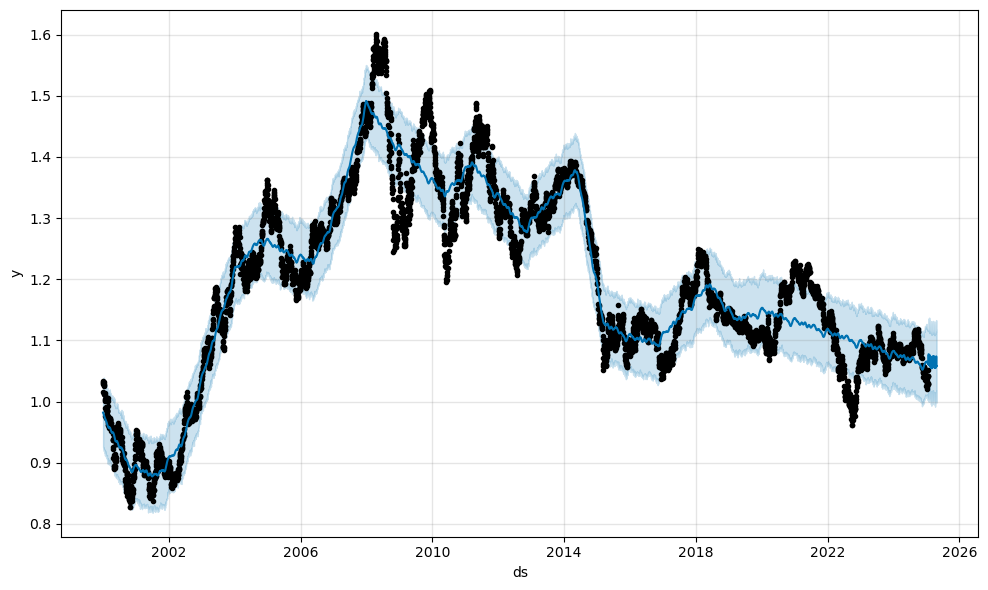

In [57]:
# Plot the Prophet predictions for the EUR trends data
m.plot(forecast_EUR_trends)

In [58]:
# Set the index in the forecast_EUR_trends DataFrame to the ds datetime column
forecast_EUR_trends = forecast_EUR_trends.set_index("ds")

# View the only the yhat,yhat_lower and yhat_upper columns from the DataFrame
forecast_EUR_trends[["yhat", "yhat_lower", "yhat_upper"]].head()


,yhat,yhat_lower,yhat_upper
ds,,,
2000-01-03,0.981999,0.925732,1.037159
2000-01-04,0.981535,0.925264,1.036998
2000-01-05,0.981142,0.924173,1.038405
2000-01-06,0.980679,0.925337,1.032892
2000-01-07,0.980178,0.922878,1.037156


<Figure size 1000x600 with 0 Axes>

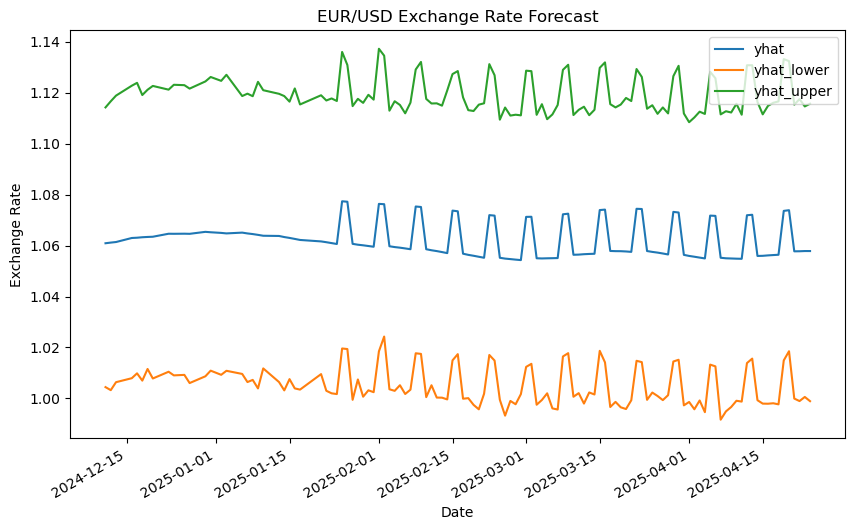

In [59]:
# From the forecast_EUR_trends DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 120 days
import pandas as pd
plt.clf()
forecast_EUR_trends[["yhat", "yhat_lower", "yhat_upper"]].iloc[-120:,:].plot(figsize=(10,6))
plt.title("EUR/USD Exchange Rate Forecast")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.show()

The prediction model of EUR in the next 90 days shows it being very stable slightly hovering around 1.06 exchange rate. This prediction doesn't capture the complex trends of changing markets and global events.

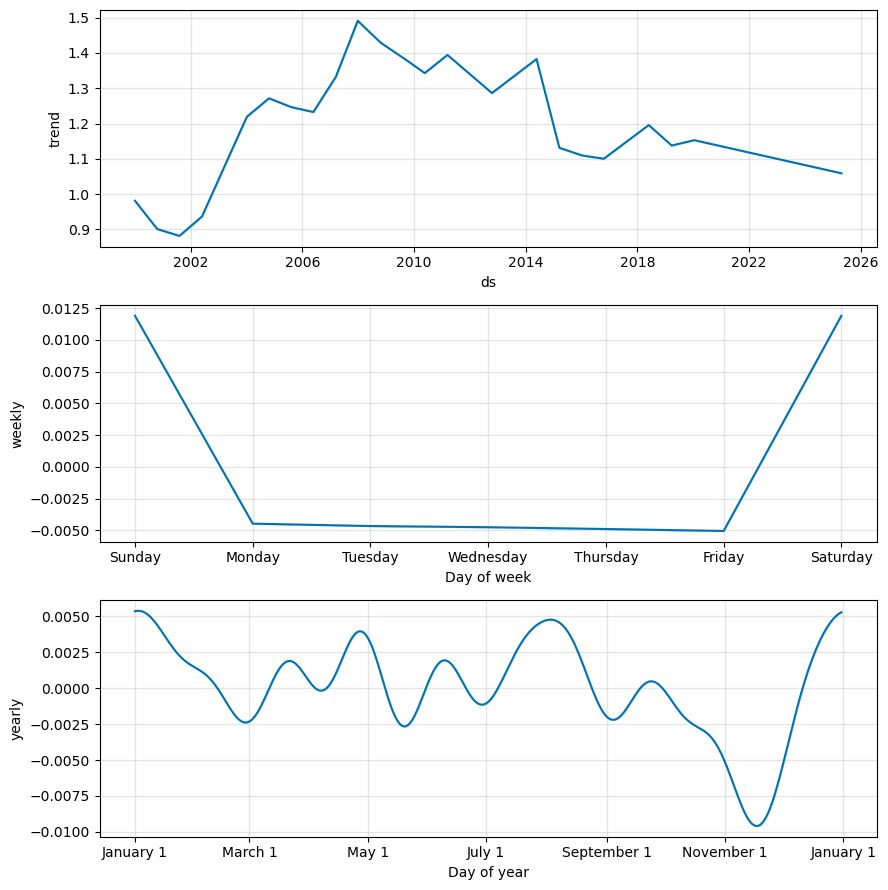

In [60]:
# Reset the index in the forecast_EUR_trends DataFrame
forecast_EUR_trends = forecast_EUR_trends.reset_index()
forecast_EUR_trends.head()

# Use the plot_components function to visualize the forecast results
# for the forecast_EUR_trends DataFrame
m.plot_components(forecast_EUR_trends)

The 'Day of the Week' graph shows a higher volatility of the EUR at the start of the week decreases towards the end of the week, supporting the idea that a currency tends to have less extreme movements from midweek toward the end of the week.

From 2006 to 2014, the EUR has the most movements and after 2014, it seems to stabilize. 

Look at the the Day of the year graph, it looks like around the end of November, the exchange rate tends to be at the lowest in the calendar year. 